**Student Name**: AJEET KUMAR

**Student Roll No**: 21F1006807

# Programming Assignment-2


Make a copy of the colab. Rename the colab as follows:

```
PA-2_<21f1006807>.ipynb
```

We will be running your colab. It should produce the graphs/charts as explaind in the problem statements. Add comments wherever necessary. At the end of each problem configuration, enter your observations in the text cell. This should include your analysis of the learning curves obtaind.

### Libraries

Stick to `NumPy` and a library such as `matplotlib`, `seaborn` or `plotly` for rendering plots.

In [98]:
## import necessary libraries here
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
np.random.seed(45)
import warnings
warnings.filterwarnings('ignore')

## Environment description

This exercise aims to familiarize you with two popular Temporal Difference Learning algorithms: **SARSA** and **Q-Learning**. You will solve several variants of the Grid World problem (a sample world is shown below in Figure 1).

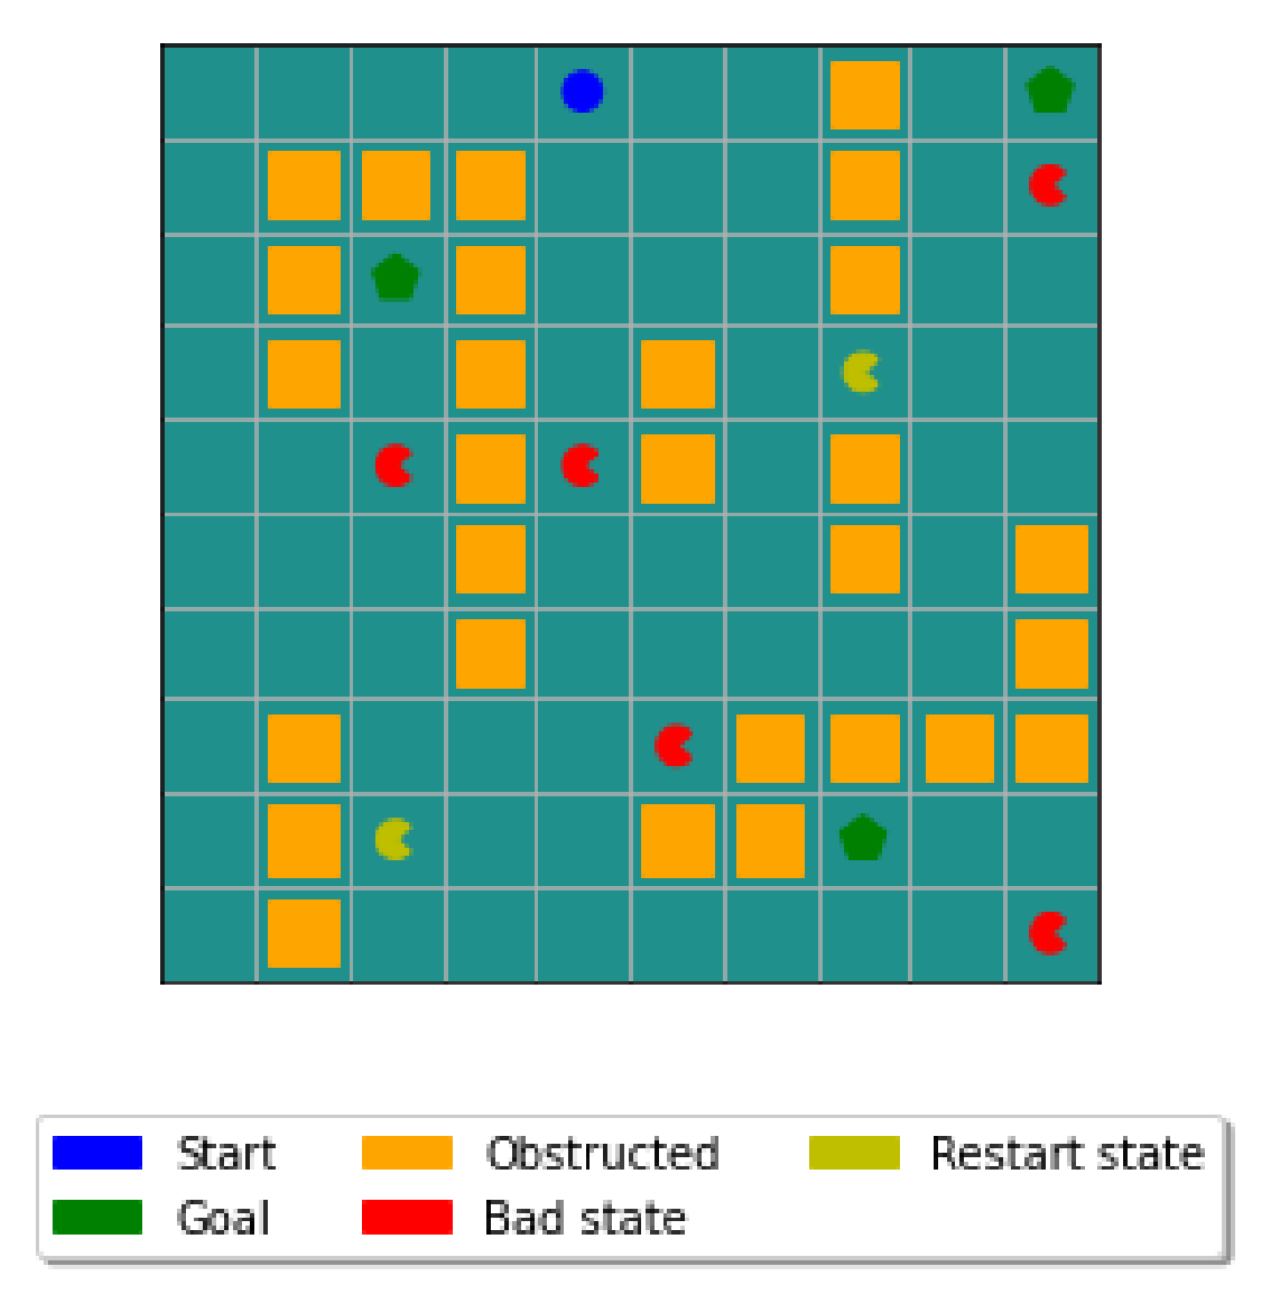

***Figure 1***

This is a grid world with 4 deterministic actions ('up', 'down', 'left', 'right'). The agent transitions to the next state determined by the direction of the action chosen with a probability of $p \in [0, 1]$. We also define a parameter called $b \in [0, 1]$ (Set $b=0.5$ for this assignment). Consider the direction of the action chosen as the agent's “North”. For example, if the action is 'left', it is the agent's North, and the agent's East would be the direction of the action 'up'. Figure 2 provides an illustration of the same. The agent transitions to the state West of the chosen action with probability $(1-p)\times b$, and to the East of the chosen action with probability $(1-p) \times (1-b)$.

 The environment may also have a wind blowing that can push the agent one **additional** cell to the right **after transitioning to the new state** with a probability of 0.4. An episode is terminated either when a goal is reached or when the timesteps exceed 100. Transitions that take you off the grid will not result in any change in state.

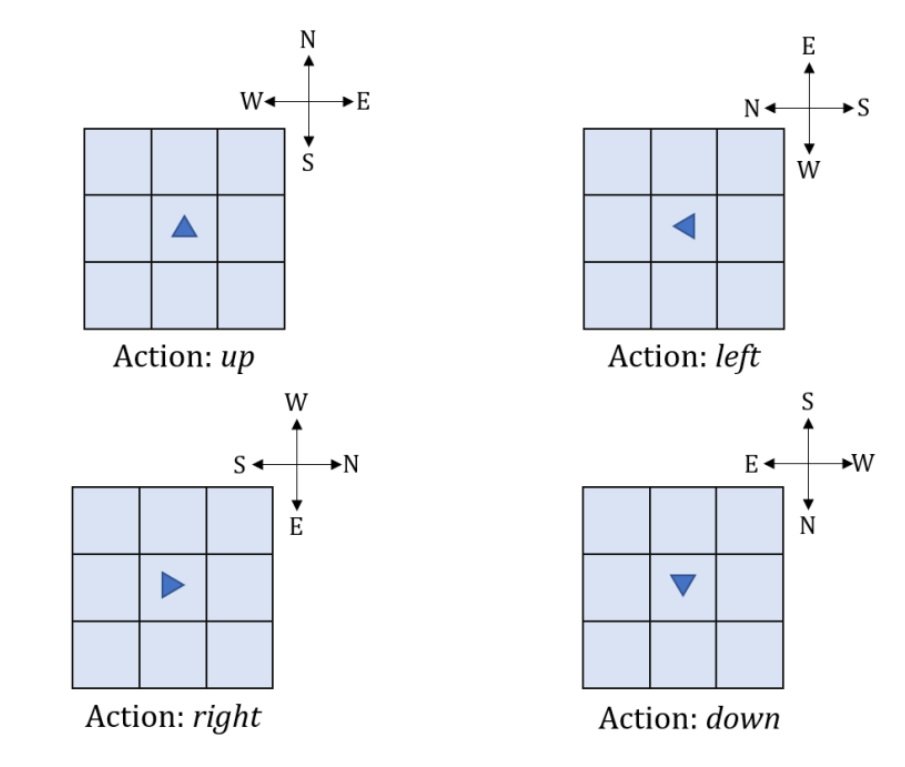

***Figure 2***

The dimensions of the grid are $10 \times 10$. The following types of states exist:

- ***Start state***: The agent starts from this state.
- ***Goal state***: The goal is to reach one of these states. There are 3 goal states in total.

- ***Obstructed state***: These are walls that prevent entry to the respective cells. Transition to these states will not result in any change.

- ***Bad state***: Entry into these states will incur a higher penalty than a normal state.
- ***Restart state***: Entry into these states will incur a very high penalty and will cause agent to teleport to the start state without the episode ending. Once the restart state is reached, no matter what action is chosen, it goes to the start state at the next step.
- ***Normal state***: None of the above. Entry into these states will incur a small penalty.


***Rewards***: -1 for normal states, -100 for restart states, -6 for bad states, +10 for goal states.

## Environment code

The code for the environment can be found below:

In [99]:
from math import floor
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

#Converts state number to row_column format
def row_col_to_seq(row_col, num_cols):
    return row_col[:,0] * num_cols + row_col[:,1]

#Converts row_column format to state number
def seq_to_col_row(seq, num_cols):
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1
        self.wind = wind

    # mark obstructed cells
    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):

                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1

        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]

    def visualize_gridworld(self):

        # create a 2D grid with empty cells
        grid_world_2D_array = np.ones((self.num_rows, self.num_cols))*ord("E")

        grid_world_2D_array[self.goal_states[:,0],self.goal_states[:,1]]= ord("G")
        grid_world_2D_array[self.obs_states[:,0],self.obs_states[:,1]]= ord("O")
        grid_world_2D_array[self.start_state[:,0],self.start_state[:,1]]= ord("S")
        grid_world_2D_array[self.bad_states[:,0],self.bad_states[:,1]]= ord("B")
        grid_world_2D_array[self.restart_states[:,0],self.restart_states[:,1]]= ord("R")

        grid_world_2D_array_colours = np.ones((self.num_rows, self.num_cols, 3))

        grid_world_2D_array_colours[grid_world_2D_array== ord("G")] =[0,1,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("O")] =[1,0.65,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("S")] =[0,0,1]
        grid_world_2D_array_colours[grid_world_2D_array== ord("B")] =[1,0,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("R")] =[1,1,0]

        fig = px.imshow(grid_world_2D_array_colours)

        state_label = np.empty_like(grid_world_2D_array,
                                    dtype ="<U10")

        state_label[grid_world_2D_array == ord("E")] ="Empty"
        state_label[grid_world_2D_array == ord("G")] ="Goal"
        state_label[grid_world_2D_array == ord("B")] ="Bad"
        state_label[grid_world_2D_array == ord("S")] ="Start"
        state_label[grid_world_2D_array == ord("R")] ="Restart"
        state_label[grid_world_2D_array == ord("O")] ="Obstacle"

        fig.update(data=[{'customdata': state_label,
                          'hovertemplate': 'x: %{x}<br>y: %{y}<br>State: %{customdata}'}])
        # add vertical and horizontal lines
        [fig.add_vline(x=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]
        [fig.add_hline(y=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]

        # ensure each row and column is numbered/labeled
        fig.update_layout(
            title ="Grid World Vizualization <br>Hover over to a cell for information",
            xaxis = dict(
                tickmode='linear',
                side='top',
                dtick=1),
            yaxis = dict(
                tickmode='linear',
                dtick=1)
        )
        fig.show()


## Environment instantiation

In [100]:
# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

In [101]:
def new_gw(wind, start_state, p):
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind)

    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)

    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=p,
                                bias=0.5)
    env = gw.create_gridworld()
    return env


## Visualize the grid world

In [102]:
# visualize the grid world configuration
env.visualize_gridworld()

## List environment variables

In [103]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


The $env.step()$ function takes as arguments the current state and action, and returns the reward and next state. The appropriate termination conditions have to be specified by the student in the code. $env.reset()$ resets the environment.

## Tasks
- Implement SARSA and Q-Learning.
- ~~For each algorithm, run experiments with wind=False and wind=True; two different start states: (0, 4), (3, 6); two values of $p$ (1.0, 0.7); and two types of exploration strategies ($\epsilon$-greedy and softmax), making it ***16 different configurations*** in total.~~
- For SARSA, there are a total of $8$ configurations:
  - set $p = 1$
  - wind could take one of two values, `True` or `False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax
- For Q-learning, there are a total of $8$ configurations:
  - $p = 1$ or $p = 0.7$
  - set `wind = False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax

- There are a total of $16$ configurations.
- For each of the $16$ configurations, determine the best set of hyperparameters (i.e. $ϵ$ in $ϵ$-greedy exploration, temperature $\beta$ in softmax exploration, learning rate $\alpha$, and discount factor $\gamma$) which maximize reward per episode over atleast 100 runs. Plot the following:
  1. Reward curves and the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).
  2. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.
  3. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.
- Try following set of values for each of the hyperparameters, for each of the configurations:

  a. learning rate ($α$) = [0.001, 0.01, 0.1, 1.0]

  b. discount factor ($γ$) = [0.7, 0.8, 0.9, 1.0]

  c. epsilon in $ϵ$-greedy = [0.001, 0.01, 0.05, 0.1] or
  
  Temperature in soft max ($τ$) = [0.01, 0.1, 1, 2]

For each of the algorithm, provide a written description of the policy learnt, explaining
the behavior of the agent, and your choice of hyperparameters. This description should
also provide information about how the behavior changes with and without the wind, for
different levels of stochasticity and for different start states.

The report can be organized in following manner:

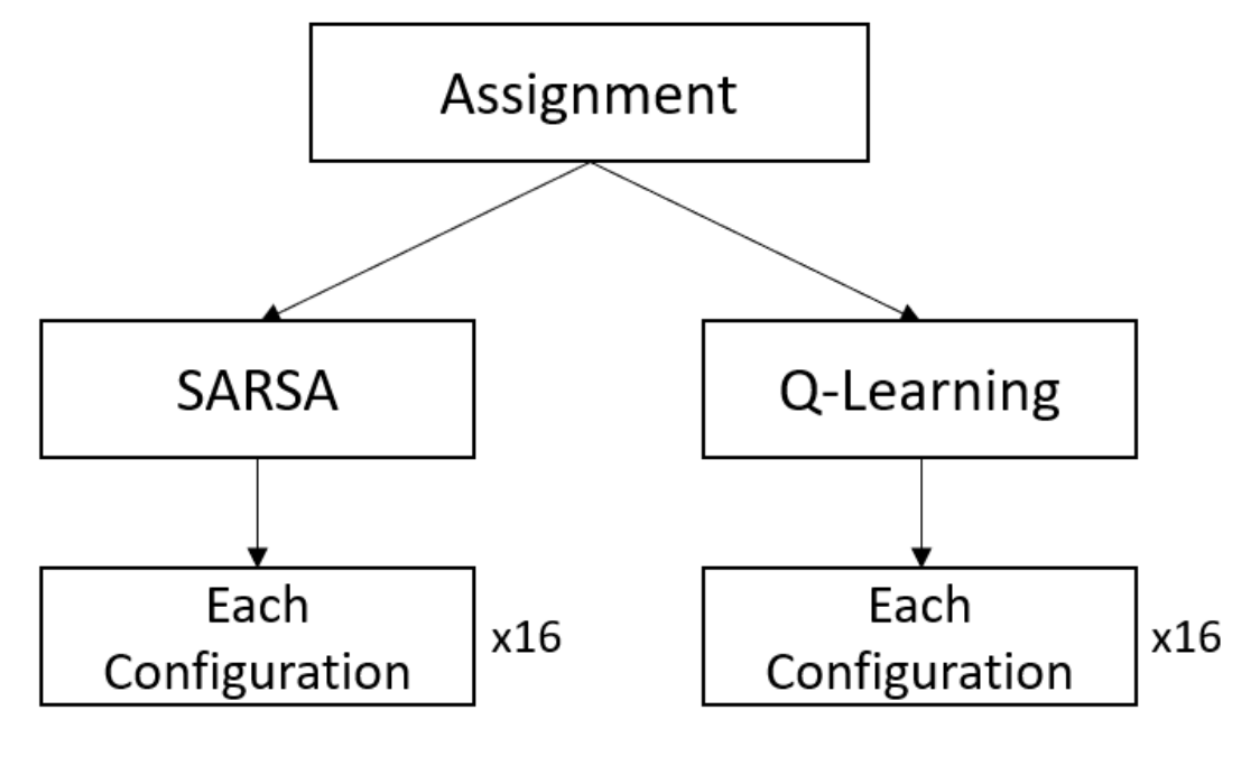

## Configurations [64 Marks]

There are total (~~32~~)16 configurations (~~16~~)8 each for SARSA and Q-Learning), each of which carry (~~2~~)4 marks.

Use below template for each of the configurations.

Hint: For reproducible results set random state appropriately.

### (1) Configuration id << insert id>>

Train the agent

In [104]:
# Hyperparameters and configurations
alphas = [0.001, 0.01, 0.1, 1.0]
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
deltas = [0.01, 0.1, 1, 2]

# Testing the environment
# alphas = [0.1]
# gammas = [0.9]
# epsilons = [0.1]
# deltas = [0.1]

In [105]:
# Configuration
configs = [(wind, start_state, strategy)
            for start_state in [(0,4), (3,6)]
            for wind in [True, False]
            for strategy in ["epsilon_greedy", "softmax"]
        ]

print(configs)

[(True, (0, 4), 'epsilon_greedy'), (True, (0, 4), 'softmax'), (False, (0, 4), 'epsilon_greedy'), (False, (0, 4), 'softmax'), (True, (3, 6), 'epsilon_greedy'), (True, (3, 6), 'softmax'), (False, (3, 6), 'epsilon_greedy'), (False, (3, 6), 'softmax')]


In [106]:
# write your code here
#sarsa
class SARSA_Agent:
    def __init__(self, alpha, gamma, strategy, strategy_param):
        self.alpha = alpha
        self.gamma = gamma
        self.strategy = strategy
        self.strategy_param = strategy_param
        self.q_values = None


    def __init__q_values(self, num_states, num_actions):
        self.q_values = np.zeros((num_states, num_actions))
    
    def choose_action(self, state):
        # if self.q_values is None:
        #     raise Exception("Q values not initialized")
        if self.strategy == "epsilon_greedy":
            if np.random.uniform(0,1) < self.strategy_param:
                return np.random.randint(0,3)
            else:
                return np.argmax(self.q_values[state])
            
        elif self.strategy == "softmax":
            q_values = self.q_values[state]
            max_q = np.max(q_values)
            exp_q = np.exp((q_values - max_q)/self.strategy_param)
            softmax_pro = exp_q / np.sum(exp_q)
            return np.random.choice(range(len(softmax_pro)), p=softmax_pro)
    
    def update_q_values(self, state, action, reward, next_state, next_action):
        td_target = reward + self.gamma * self.q_values[next_state][next_action]
        td_error = td_target - self.q_values[state][action]
        self.q_values[state][action] += self.alpha * td_error
    
    def train(self, env, num_episodes):
        num_states = env.num_states
        num_actions = env.num_actions

        self.__init__q_values(num_states, num_actions)
        rewards_per_episode = []
        steps_per_episode = []
        state_visit_counts = np.zeros(num_states)

        for _ in range(num_episodes):
            state = env.reset()
            action = self.choose_action(state)
            total_reward = 0
            steps = 0
            max_steps = 500

            while True:
                next_state, reward = env.step(state, action)
                next_action = self.choose_action(next_state)
                self.update_q_values(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
                total_reward += reward
                steps += 1
                state_visit_counts[state] += 1
                # Breaking the loop if the agent reaches the goal state or the maximum number of steps is reached

                if state in env.goal_states_seq or steps>= max_steps:
                    break

            rewards_per_episode.append(total_reward)
            steps_per_episode.append(steps)
        return rewards_per_episode, steps_per_episode, state_visit_counts
    
    def get_q_values(self):
        optimal_actions = np.argmax(self.q_values, axis=1)
        return self.q_values, optimal_actions



In [107]:
def execution(config):
    wind, start_state, strategy = config
    best_hyperparameters = None
    best_reward = -np.inf
    env = new_gw(wind, np.array([start_state]), p=1)

    for alpha in alphas:
        for gamma in gammas:
            if strategy == "epsilon_greedy":
                for epsilon in epsilons:
                    for i in range(50):
                        agent = SARSA_Agent(alpha, gamma, strategy, epsilon)
                        rewards, steps, state_visit_counts = agent.train(env, num_episodes=1000)
                        avg_reward = np.mean(rewards)
                        if avg_reward > best_reward:
                            best_reward = avg_reward
                            best_hyperparameters = (alpha, gamma, epsilon)

            elif strategy == "softmax":
                for delta in deltas:
                    for i in range(50):
                        agent = SARSA_Agent(alpha, gamma, strategy, delta)
                        rewards, steps, state_visit_counts = agent.train(env, num_episodes=1000)
                        avg_reward = np.mean(rewards)
                        if avg_reward > best_reward:
                            best_reward = avg_reward
                            best_hyperparameters = (alpha, gamma, delta)

    agent = SARSA_Agent(best_hyperparameters[0],best_hyperparameters[1], strategy, best_hyperparameters[2])
    
    rewards, steps, state_visit_counts = agent.train(env, num_episodes=1000)

    # Print best rewards, steps, and state visits
    print("Best Configuration:", config)
    print("Best Hyperparameters: alpha =", best_hyperparameters[0], ", gamma =", best_hyperparameters[1], ", strategy_value =", best_hyperparameters[2])
    print("Best Rewards:", np.sum(rewards))
    print("Best Steps:", len(steps))

    # Plotting the results
       # Plot best rewards with steps
    plt.figure(figsize=(12, 5))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Best Reward Curve{config}')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(steps)
    plt.xlabel('Episode')
    plt.ylabel('Steps to Goal')
    plt.title(f'Steps to Goal for Config {config}')
    plt.show()

    # Heatmap of state visits
    plt.figure(figsize=(12, 5))
    sns.heatmap(state_visit_counts.reshape(num_rows, num_cols), annot=True, cmap='viridis', fmt='.2f', annot_kws={'size':6})
    plt.title(f'State Visit Counts for Config {config}', fontsize=9)
    plt.show()

    # Heatmap of Q values and optimal actions
    q_values, optimal_actions = agent.get_q_values() #state, action
    plt.figure(figsize=(12, 5))
    sns.heatmap(q_values.max(axis=1).reshape(num_rows, num_cols), annot=True, cmap='viridis', fmt='.2f',annot_kws={'size':7})
    plt.title(f'Q Values for Config {config}')
    plt.show()


1. Plot reward curves (during the training phase with the best hyperparameters).

#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = Epsilon Greedy

Best Configuration: (True, (0, 4), 'epsilon_greedy')
Best Hyperparameters: alpha = 1 , gamma = 0.9 , strategy_value = 0.001
Best Rewards: -14562.0
Best Steps: 1000


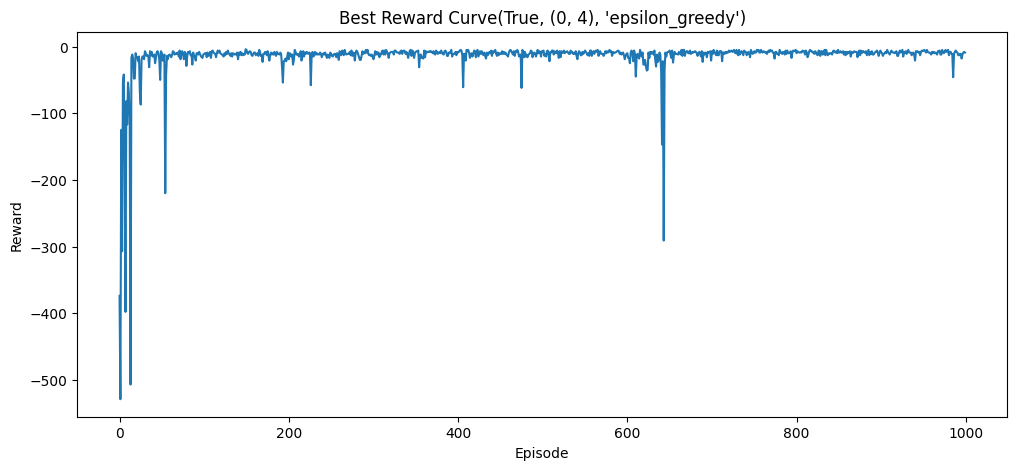

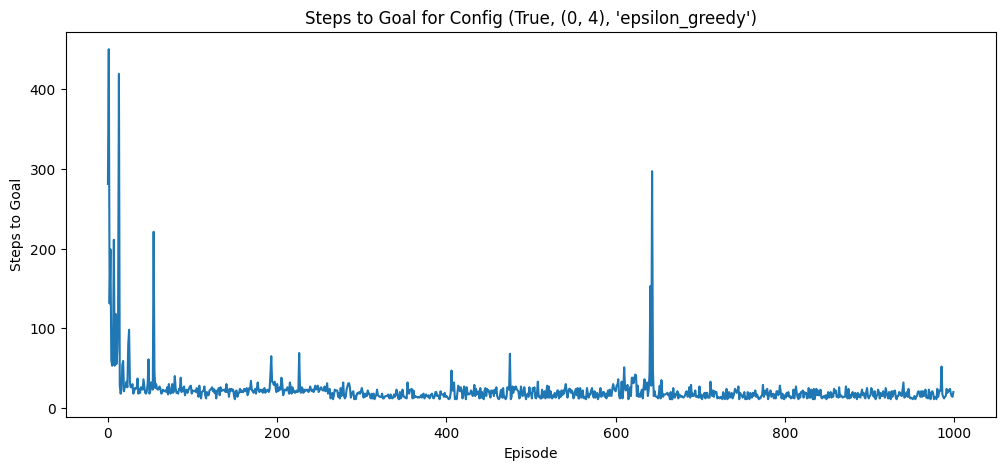

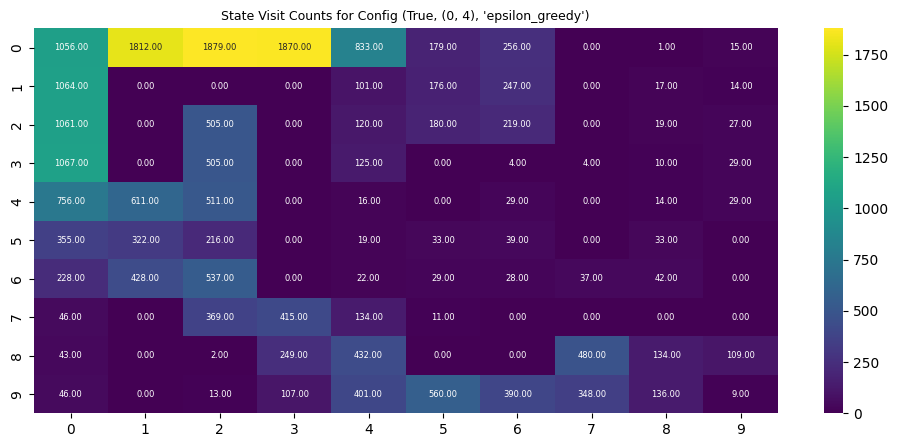

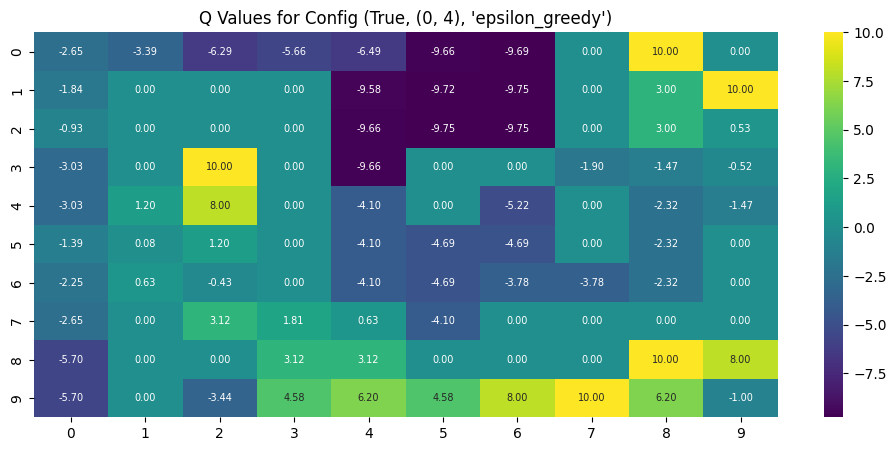

In [109]:
# traing the agent on best parameters
execution(configs[0])


#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = Softmax

Best Configuration: (True, (0, 4), 'softmax')
Best Hyperparameters: alpha = 1 , gamma = 0.9 , strategy_value = 0.1
Best Rewards: -14914.0
Best Steps: 1000


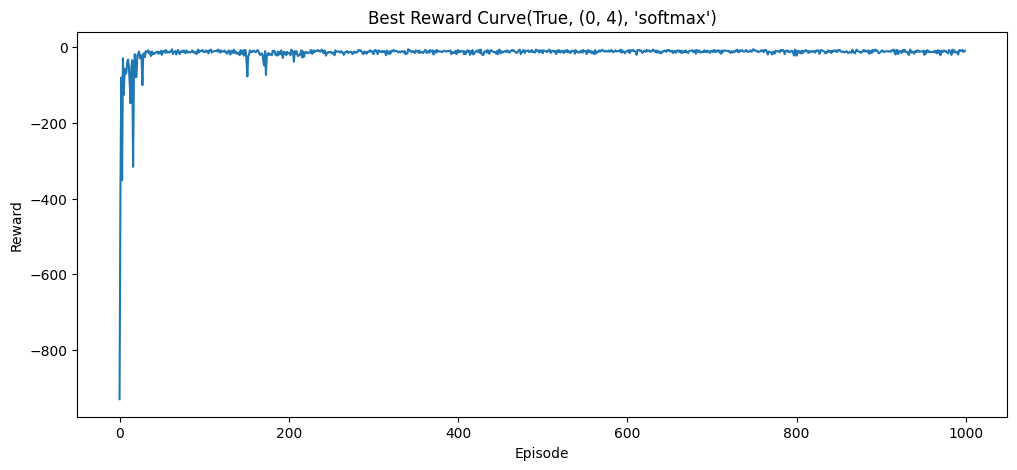

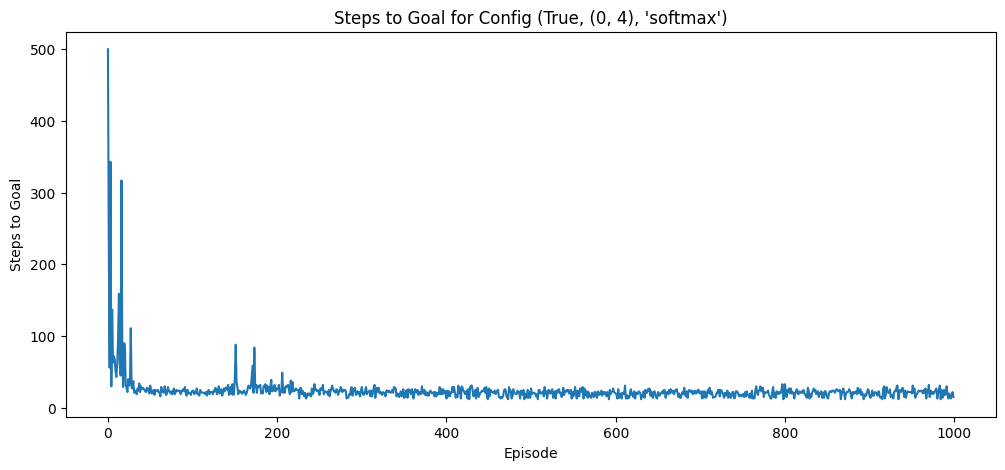

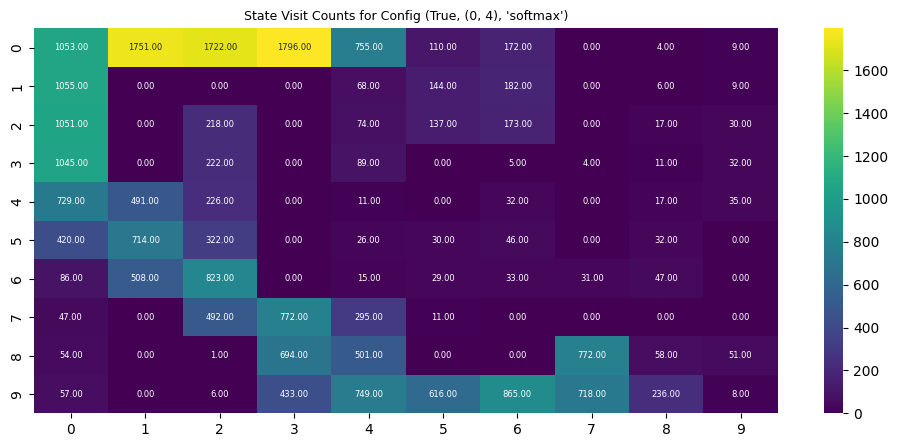

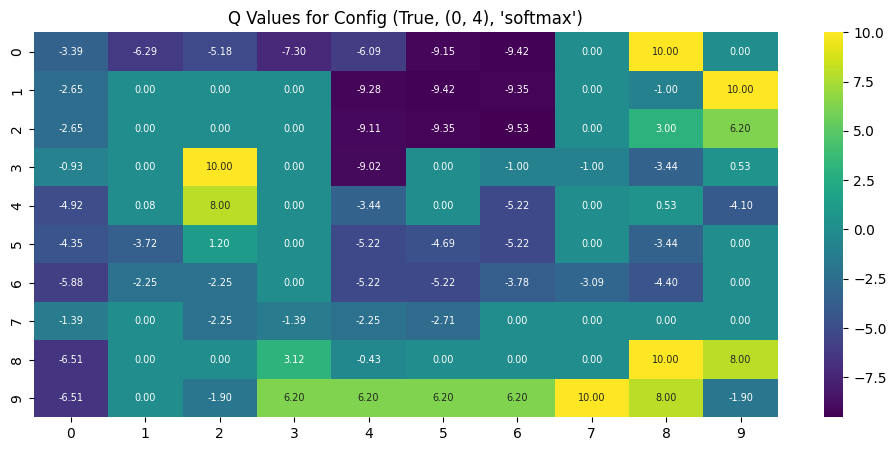

In [111]:
# traing the agent on best parameters
execution(configs[1])

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = Epsilon Greedy

Best Configuration: (False, (0, 4), 'epsilon_greedy')
Best Hyperparameters: alpha = 1 , gamma = 1 , strategy_value = 0.001
Best Rewards: -10500.0
Best Steps: 1000


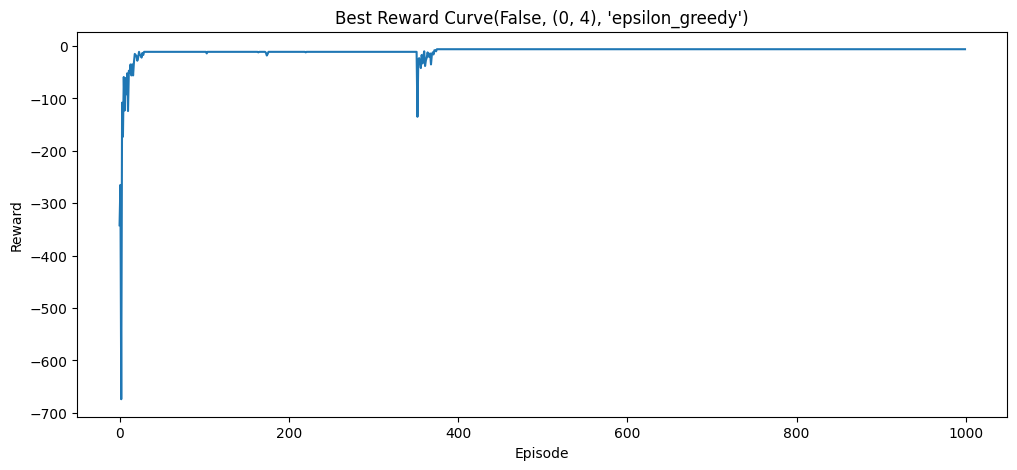

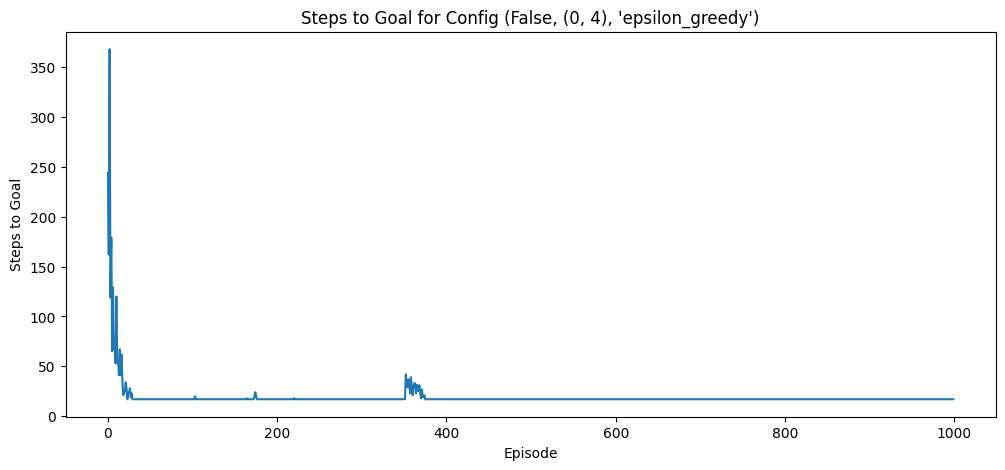

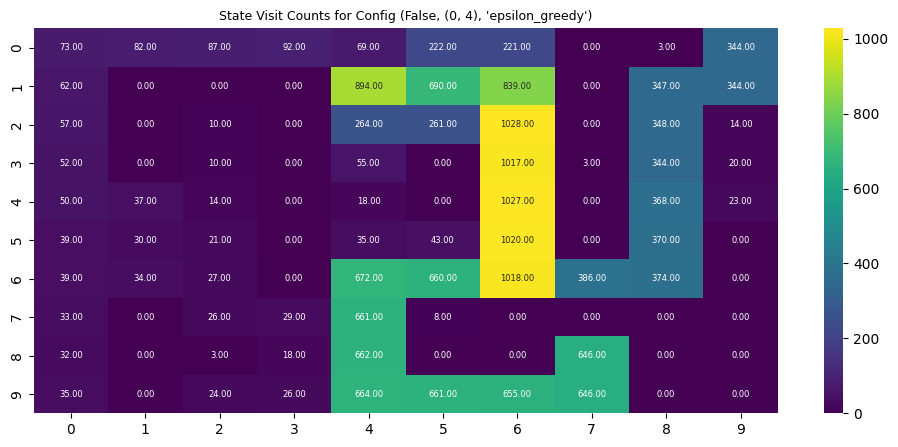

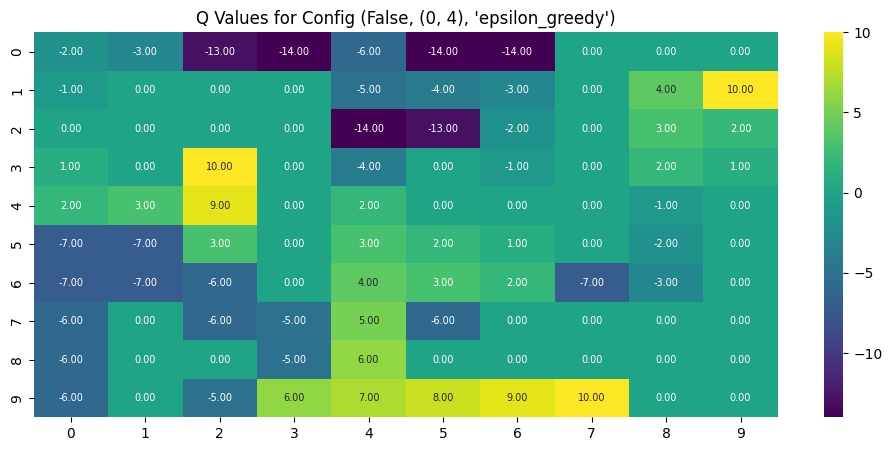

In [113]:
# traing the agent on best parameters
execution(configs[2])

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = Softmax

Best Configuration: (False, (0, 4), 'softmax')
Best Hyperparameters: alpha = 1 , gamma = 1 , strategy_value = 0.001
Best Rewards: -13392.0
Best Steps: 1000


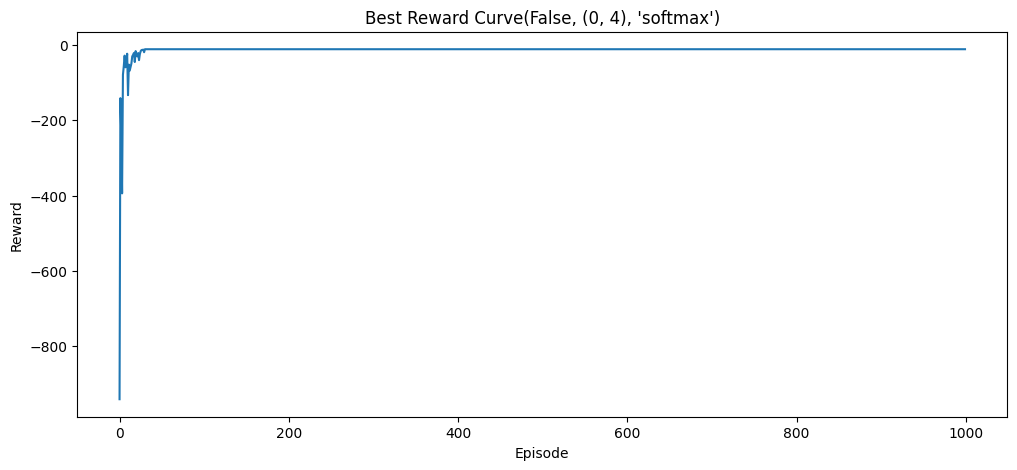

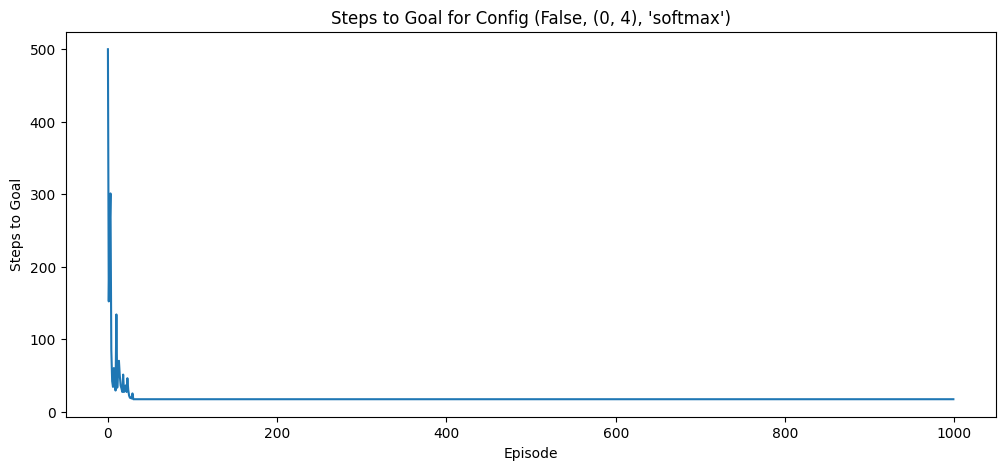

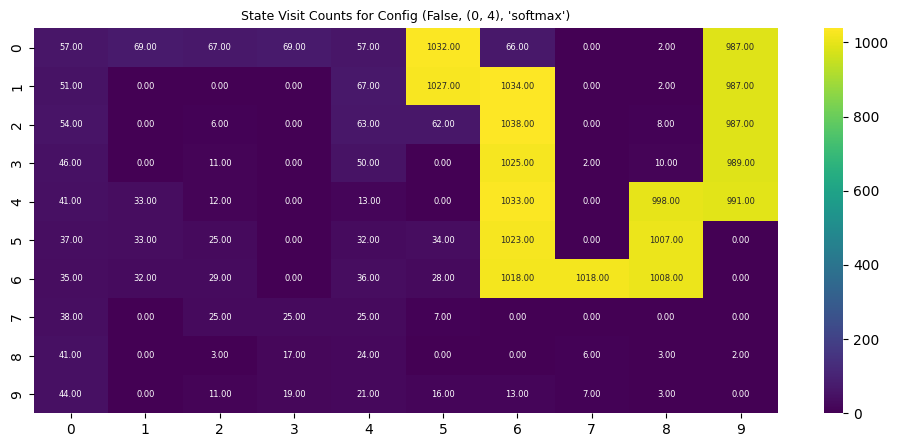

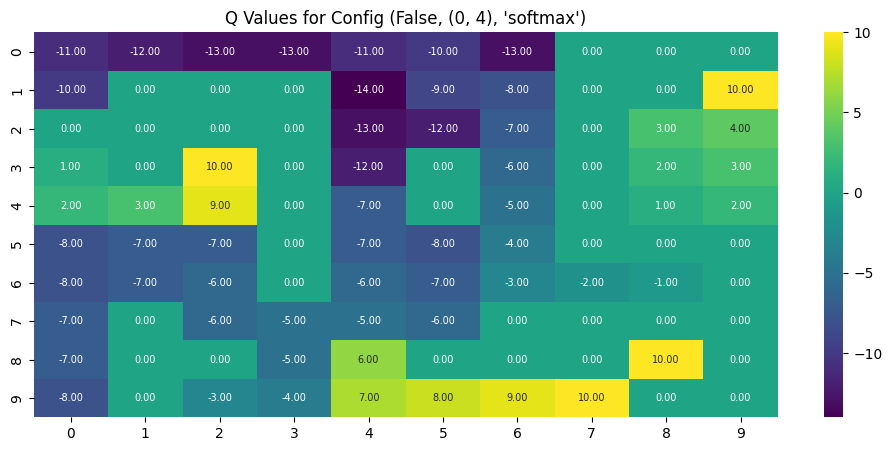

In [115]:
# traing the agent on best parameters
execution(configs[3])

#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = Epsilon Greedy

Best Configuration: (True, (3, 6), 'epsilon_greedy')
Best Hyperparameters: alpha = 1 , gamma = 0.9 , strategy_value = 0.001
Best Rewards: -22331.0
Best Steps: 1000


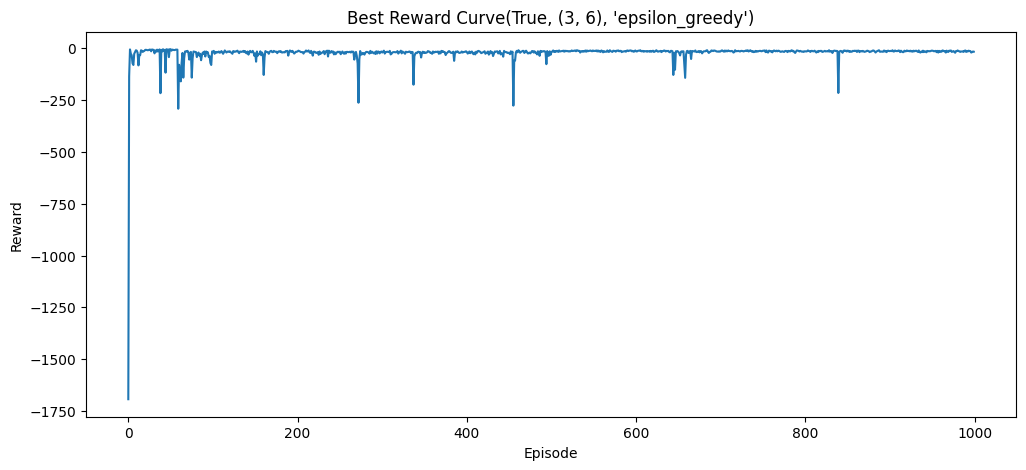

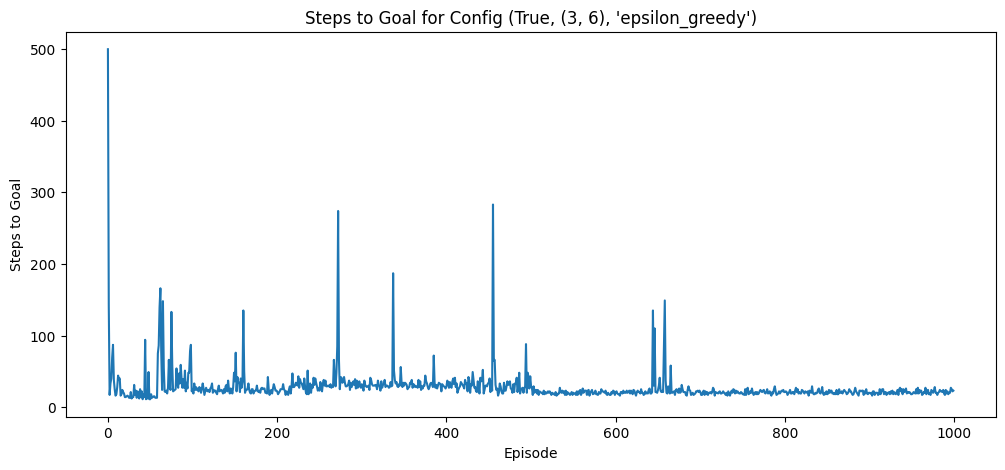

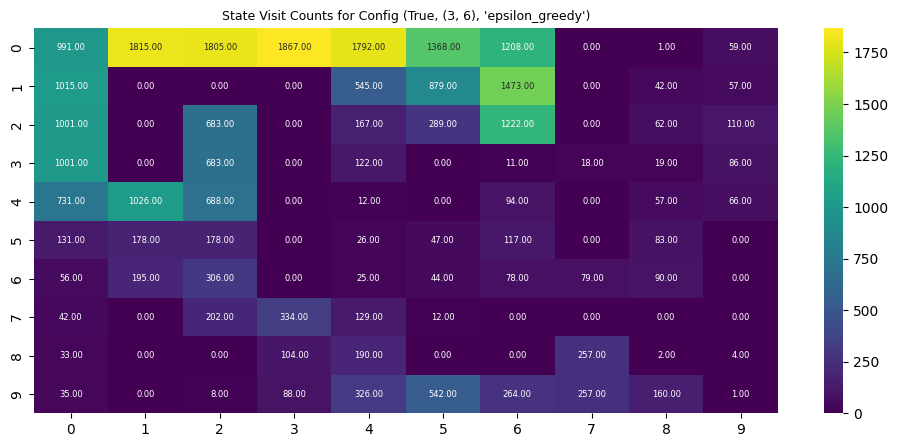

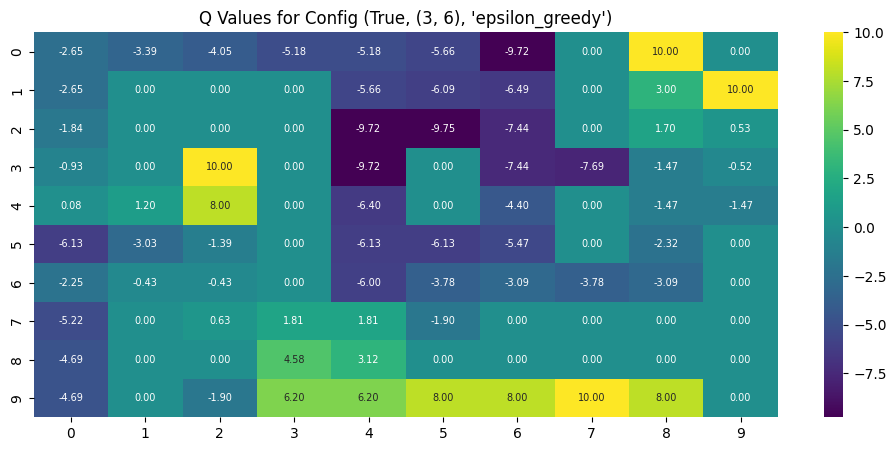

In [117]:
# traing the agent on best parameters
execution(configs[4])

#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = Softmax

Best Configuration: (True, (3, 6), 'softmax')
Best Hyperparameters: alpha = 1 , gamma = 0.9 , strategy_value = 0.1
Best Rewards: -10116.0
Best Steps: 1000


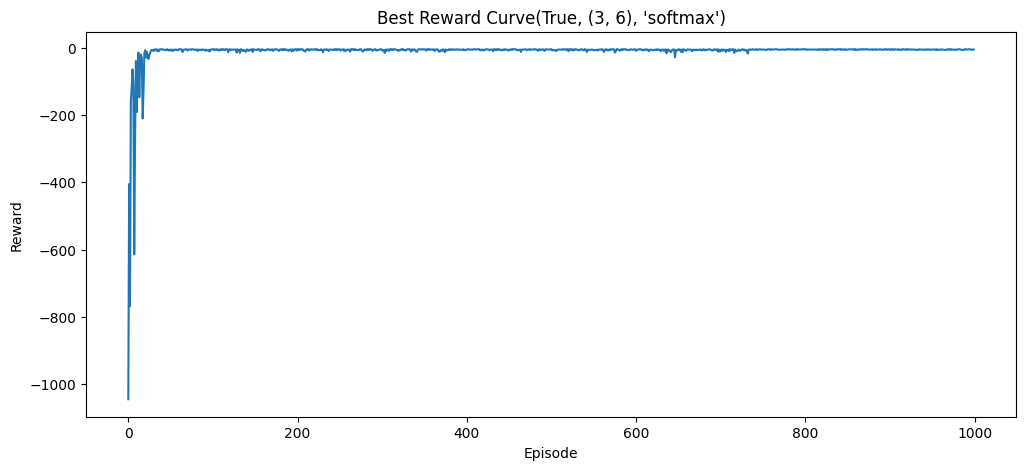

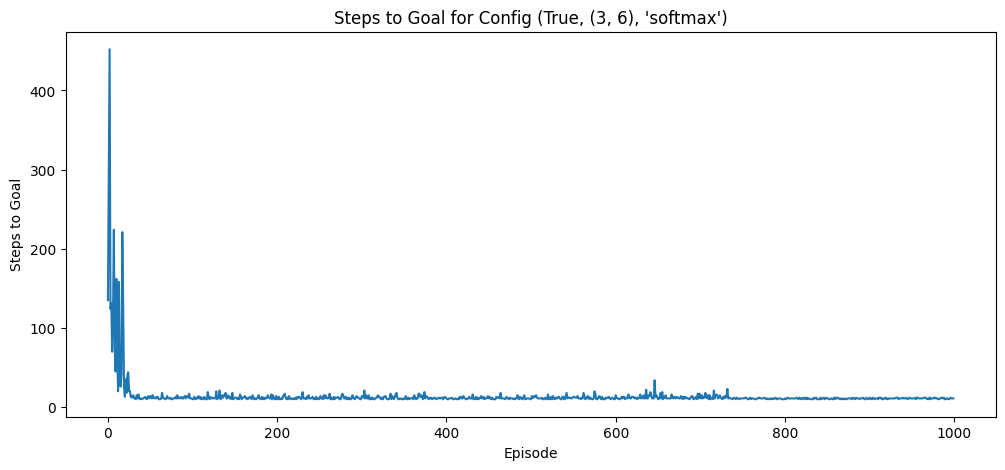

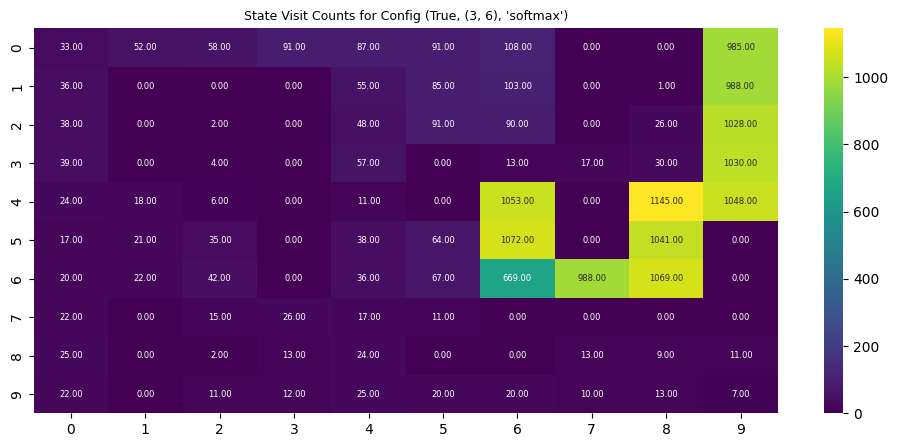

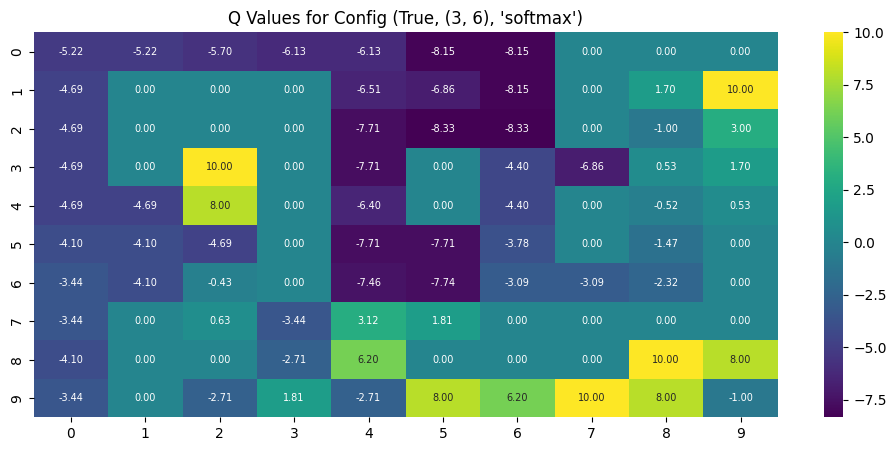

In [119]:
# traing the agent on best parameters
execution(configs[5])

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = Epsilon Greedy

Best Configuration: (False, (3, 6), 'epsilon_greedy')
Best Hyperparameters: alpha = 1 , gamma = 1 , strategy_value = 0.001
Best Rewards: -8393.0
Best Steps: 1000


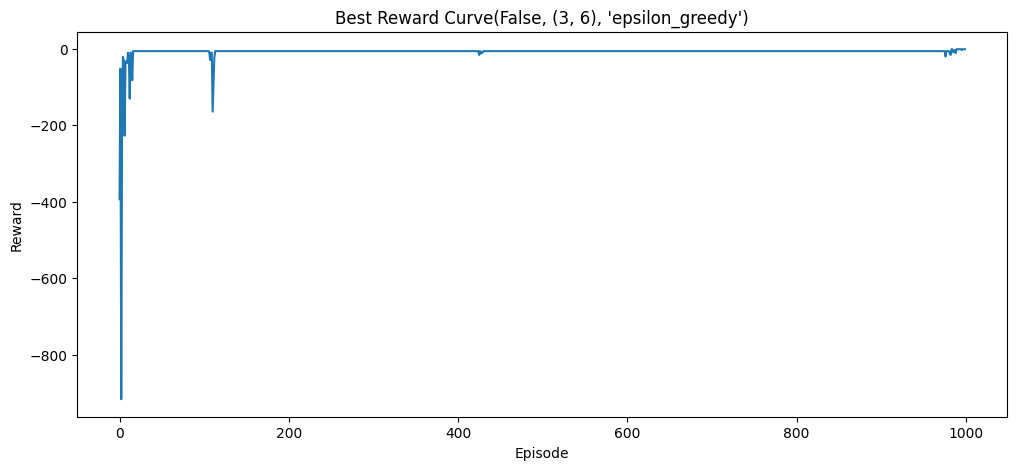

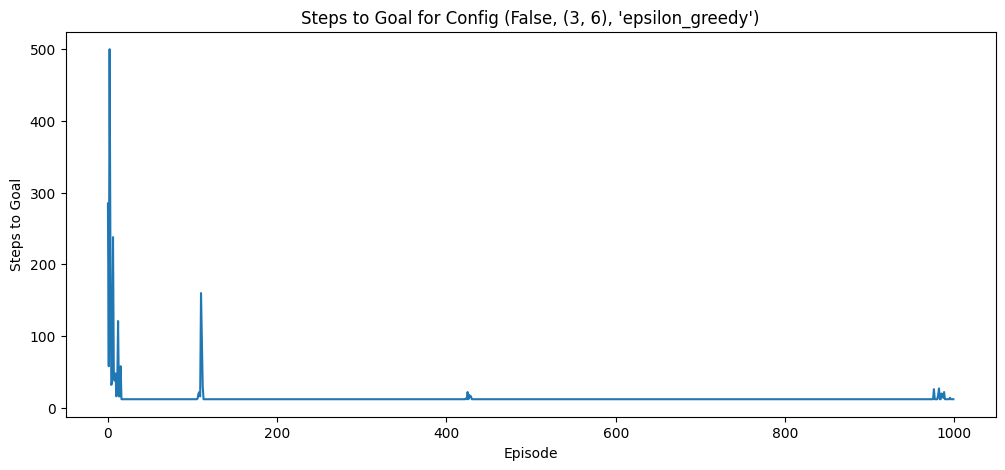

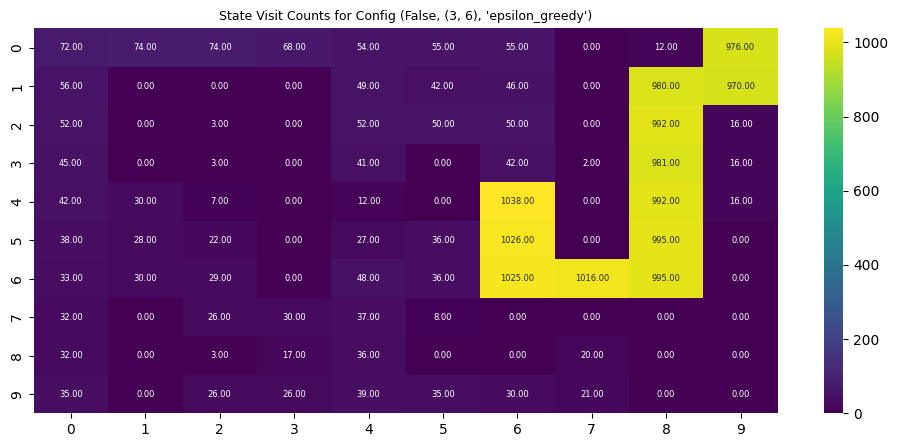

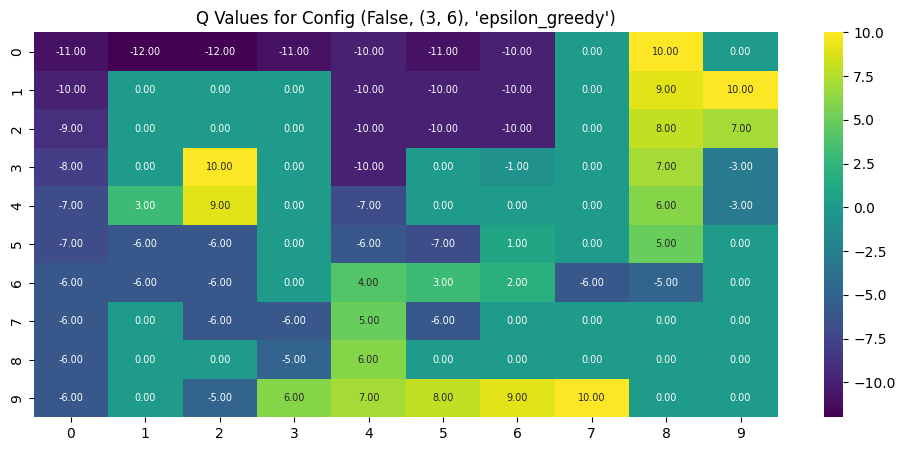

In [121]:
# traing the agent on best parameters
execution(configs[6])

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = Softmax

Best Configuration: (False, (3, 6), 'softmax')
Best Hyperparameters: alpha = 1 , gamma = 0.9 , strategy_value = 0.01
Best Rewards: -3577.0
Best Steps: 1000


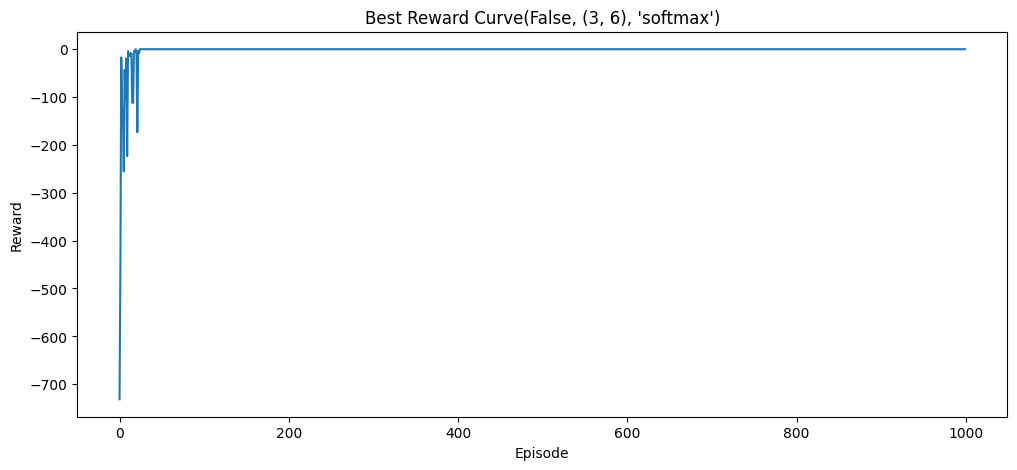

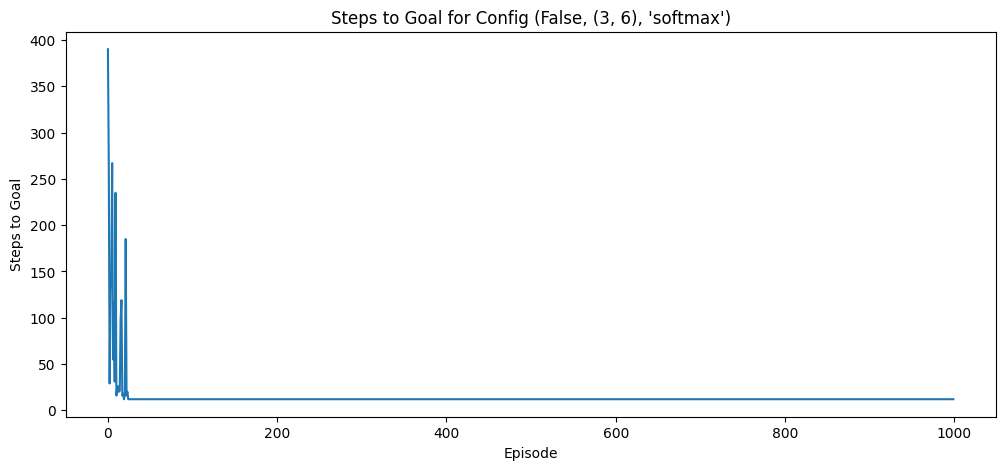

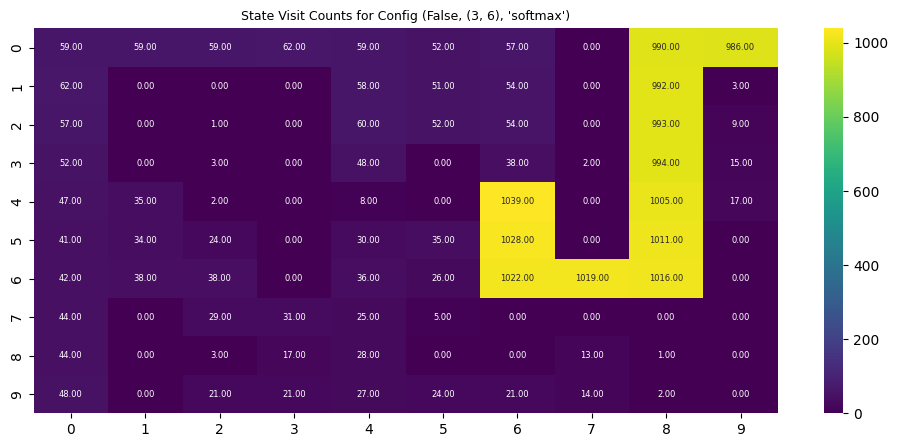

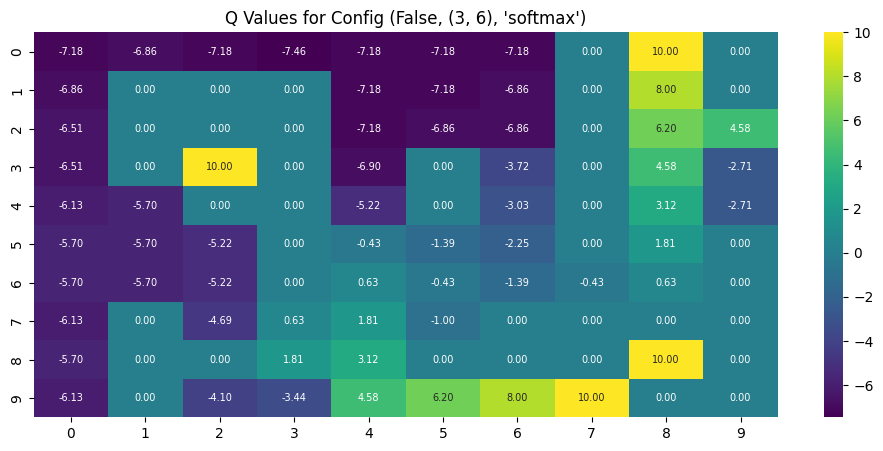

In [123]:
# traing the agent on best parameters
execution(configs[7])

## Q_Learning

In [124]:
# Hyperparameters and configurations
alphas = [0.001,0.01,0.1,1]
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
deltas = [0.01, 0.1, 1, 2]

#Testing
# alphas = [0.1]
# gammas = [0.9]
# epsilons = [0.1]
# deltas = [0.1]


In [125]:
# write your code here
configs = [
    (p, start_state, strategy)
    for start_state in [(0, 4),(3,6)]
    for p in [1,0.7]
    for strategy in ['epsilon_greedy', 'softmax']
]

In [126]:
print(configs)

[(1, (0, 4), 'epsilon_greedy'), (1, (0, 4), 'softmax'), (0.7, (0, 4), 'epsilon_greedy'), (0.7, (0, 4), 'softmax'), (1, (3, 6), 'epsilon_greedy'), (1, (3, 6), 'softmax'), (0.7, (3, 6), 'epsilon_greedy'), (0.7, (3, 6), 'softmax')]


In [127]:
class QLearning_Agent:
    def __init__(self, alpha, gamma, strategy, strategy_param):
        self.alpha = alpha
        self.gamma = gamma
        self.strategy = strategy
        self.strategy_param = strategy_param
        self.q_values = None

    def __init__q_values(self, num_states, num_actions):
        self.q_values = np.zeros((num_states, num_actions))
    
    def choose_action(self, state):
        if self.strategy == "epsilon_greedy":
            if np.random.uniform(0,1) < self.strategy_param:
                return np.random.randint(0,3)
            else:
                return np.argmax(self.q_values[state])
            
        elif self.strategy == "softmax":
            q_values = self.q_values[state]
            max_q = np.max(q_values)
            exp_q = np.exp((q_values - max_q)/self.strategy_param)
            softmax_pro = exp_q / np.sum(exp_q)
            return np.random.choice(range(len(softmax_pro)), p=softmax_pro)
    
    def update_q_values(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_values[next_state])
        td_target = reward + self.gamma * self.q_values[next_state][best_next_action]
        td_error = td_target - self.q_values[state][action]
        self.q_values[state][action] += self.alpha * td_error
    
    def train(self, env, num_episodes):
        num_states = env.num_states
        num_actions = env.num_actions

        self.__init__q_values(num_states, num_actions)
        rewards_per_episode = []
        steps_per_episode = []
        state_visit_counts = np.zeros(num_states)

        for _ in range(num_episodes):
            state = env.reset()
            total_reward = 0
            steps = 0
            max_steps = 500

            while True:
                action = self.choose_action(state)
                next_state, reward = env.step(state, action)
                self.update_q_values(state, action, reward, next_state)
                state = next_state
                total_reward += reward
                steps += 1
                state_visit_counts[state] += 1
                # Breaking the loop if the agent reaches the goal state or the maximum number of steps is reached

                if state in env.goal_states_seq or steps>= max_steps:
                    break

            rewards_per_episode.append(total_reward)
            steps_per_episode.append(steps)
        return rewards_per_episode, steps_per_episode, state_visit_counts
    
    def get_q_values(self):
        optimal_actions = np.argmax(self.q_values, axis=1)
        return self.q_values, optimal_actions

In [128]:
def QLearning_Execution(config):
    p, start_state, strategy = config
    best_hyperparameters = None
    best_reward = -np.inf
    env = new_gw(wind=False, start_state=np.array([start_state]), p=p)

    for alpha in alphas:
        for gamma in gammas:
            if strategy == "epsilon_greedy":
                for epsilon in epsilons:
                    for i in range(50):
                        agent = QLearning_Agent(alpha, gamma, strategy, epsilon)
                        rewards, steps, state_visit_counts = agent.train(env, num_episodes=1000)
                        avg_reward = np.mean(rewards)
                        if avg_reward > best_reward:
                            best_reward = avg_reward
                            best_hyperparameters = (alpha, gamma, epsilon)

            else:
                for delta in deltas:
                    for i in range(50):
                        agent = QLearning_Agent(alpha, gamma, strategy, delta)
                        rewards, steps, state_visit_counts = agent.train(env, num_episodes=1000)
                        avg_reward = np.mean(rewards)
                        if avg_reward > best_reward:
                            best_reward = avg_reward
                            best_hyperparameters = (alpha, gamma, delta)

    agent = QLearning_Agent(best_hyperparameters[0],best_hyperparameters[1], strategy, best_hyperparameters[2])
    
    rewards, steps, state_visit_counts = agent.train(env, num_episodes=1000)

    # Print best rewards, steps, and state visits
    print("Best Configuration:", config)
    print("Best Hyperparameters: alpha =", best_hyperparameters[0], ", gamma =", best_hyperparameters[1], ", strategy_value =", best_hyperparameters[2])
    print("Best Rewards:", np.sum(rewards))
    print("Best Steps:", len(steps))

    # Plotting the results
       # Plot best rewards with steps
    plt.figure(figsize=(12, 5))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Best Reward Curve{config}')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(steps)
    plt.xlabel('Episode')
    plt.ylabel('Steps to Goal')
    plt.title(f'Steps to Goal for Config {config}')
    plt.show()

    # Heatmap of state visits
    plt.figure(figsize=(12, 5))
    sns.heatmap(state_visit_counts.reshape(num_rows, num_cols), annot=True, cmap='viridis', fmt='.2f', annot_kws={'size':6})
    plt.title(f'State Visit Counts for Config {config}', fontsize=9)
    plt.show()

    # Heatmap of Q values and optimal actions
    q_values, optimal_actions = agent.get_q_values() #state, action
    plt.figure(figsize=(12, 5))
    sns.heatmap(q_values.max(axis=1).reshape(num_rows, num_cols), annot=True, cmap='viridis', fmt='.2f',annot_kws={'size':7})
    plt.title(f'Q Values for Config {config}')
    plt.show()

    

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = Epsilon Greedy

Best Configuration: (1, (0, 4), 'epsilon_greedy')
Best Hyperparameters: alpha = 1 , gamma = 1 , strategy_value = 0.01
Best Rewards: -14209.0
Best Steps: 1000


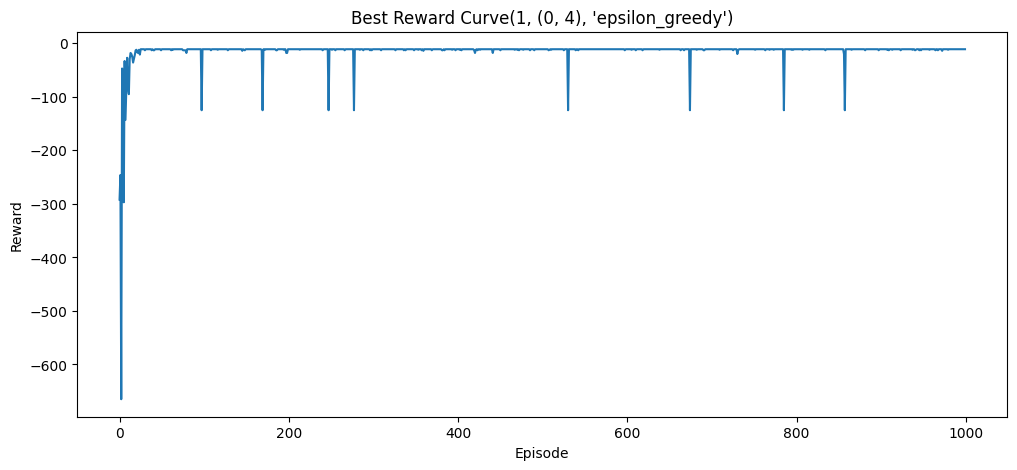

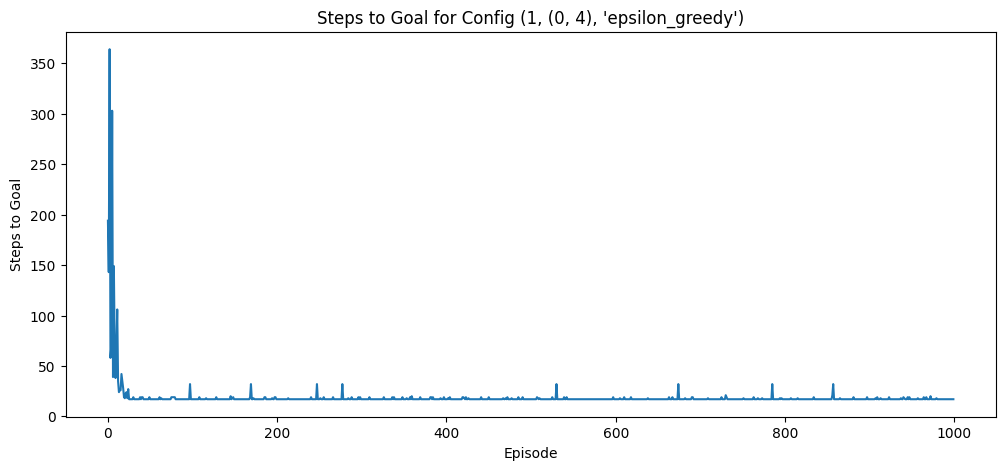

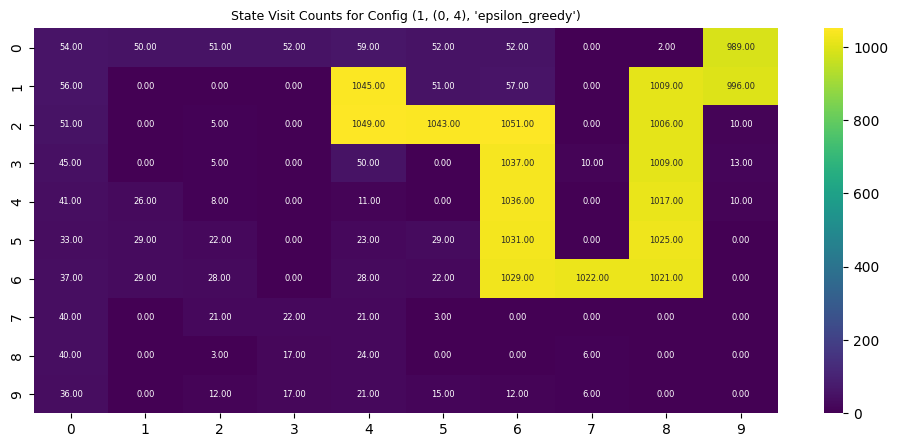

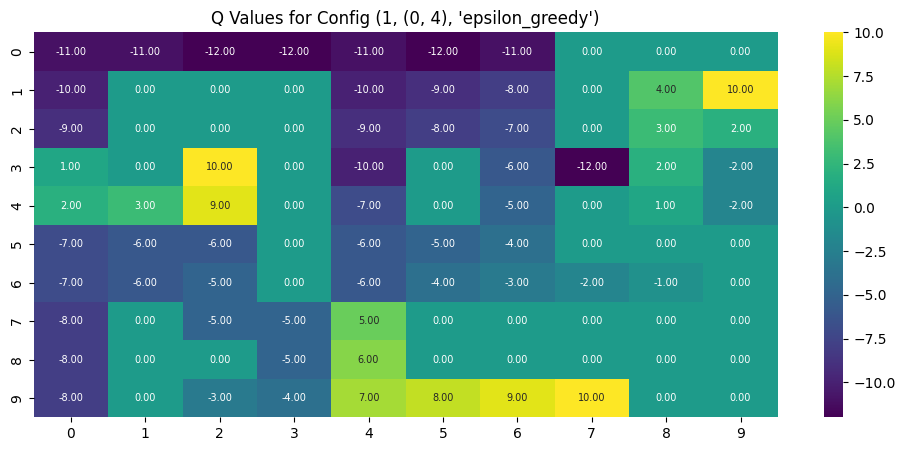

In [130]:
# plotting the results for the best hyperparameters
QLearning_Execution(configs[0])

#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = Softmax

Best Configuration: (1, (0, 4), 'softmax')
Best Hyperparameters: alpha = 1 , gamma = 0.8 , strategy_value = 0.01
Best Rewards: -8338.0
Best Steps: 1000


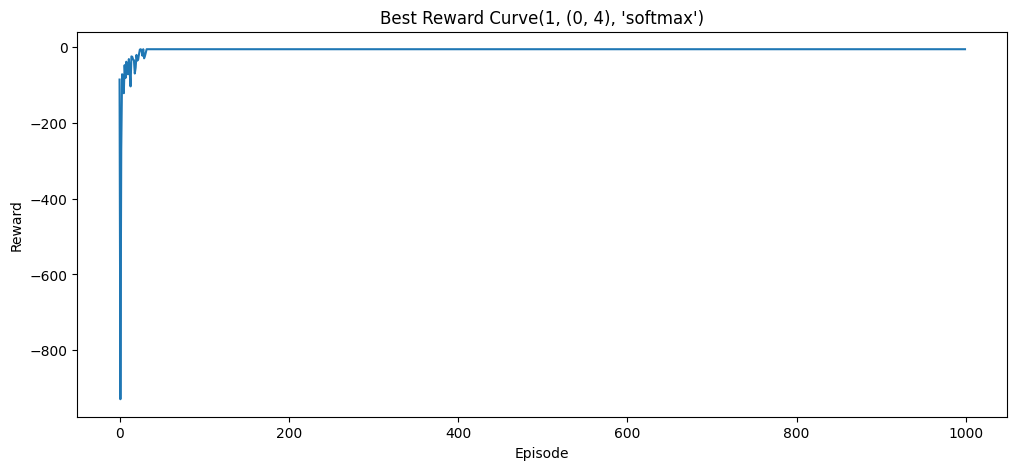

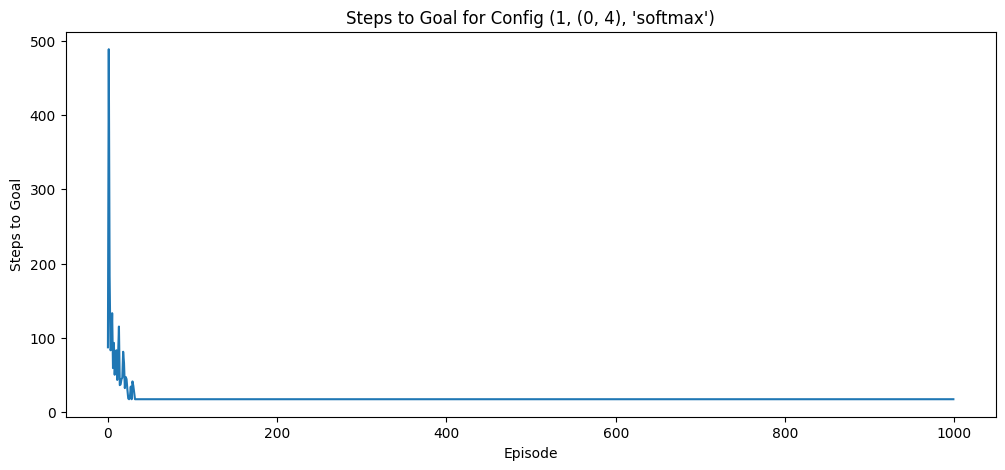

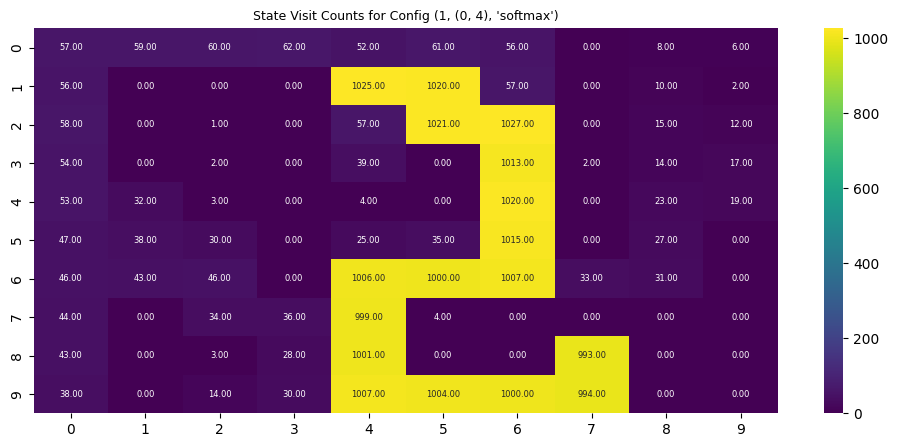

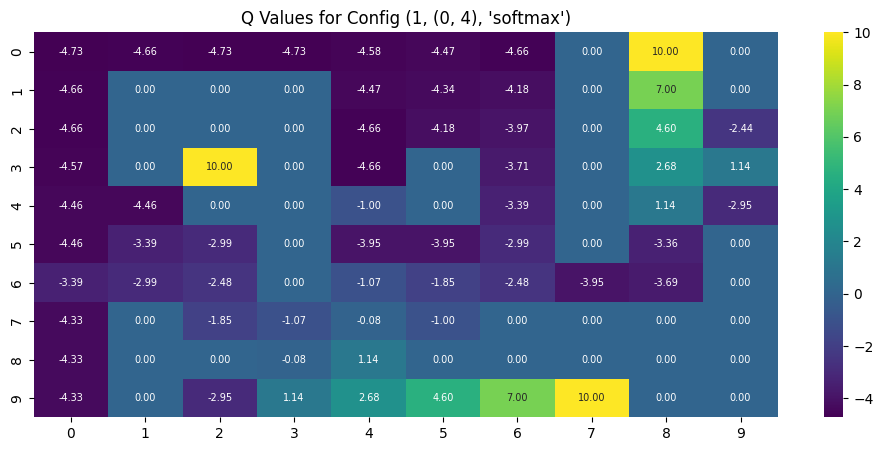

In [132]:
QLearning_Execution(configs[1])


#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (0,4)

Value of $p$ = 0.7

Exploration strategy = Epsilon Greedy

Best Configuration: (0.7, (0, 4), 'epsilon_greedy')
Best Hyperparameters: alpha = 1 , gamma = 1 , strategy_value = 0.001
Best Rewards: -39315.0
Best Steps: 1000


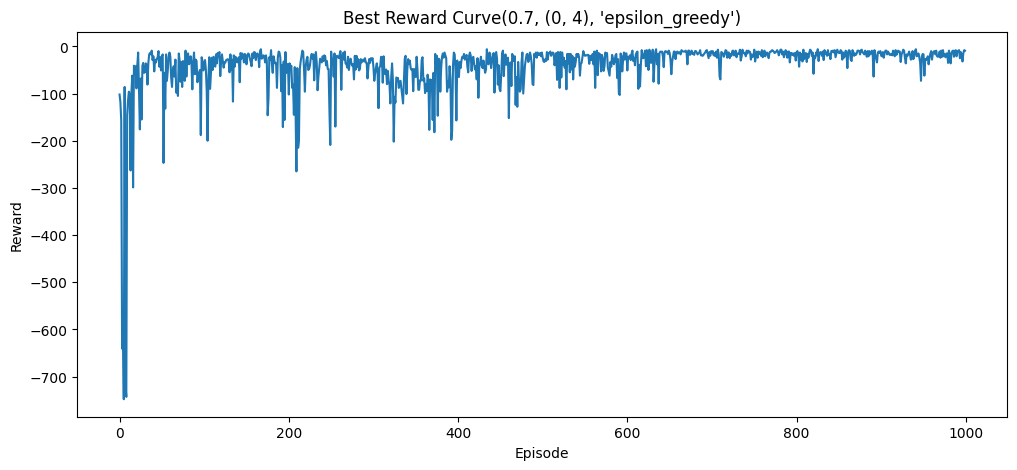

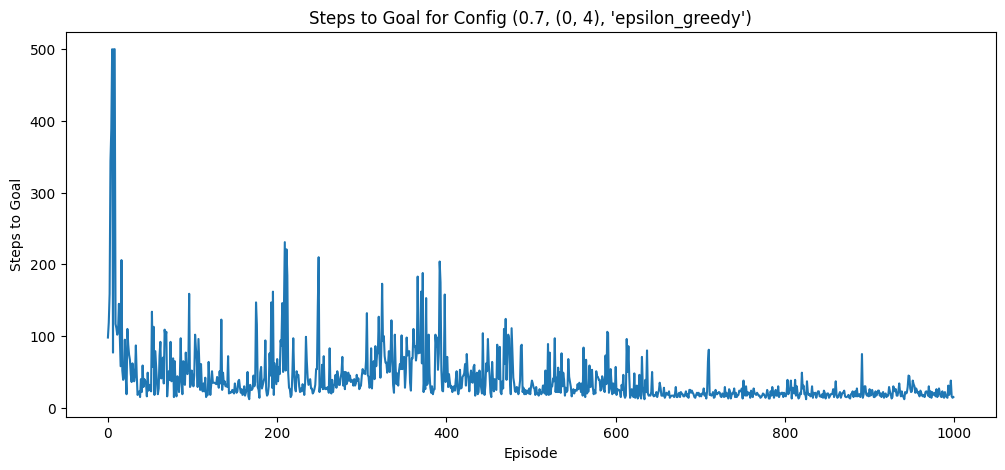

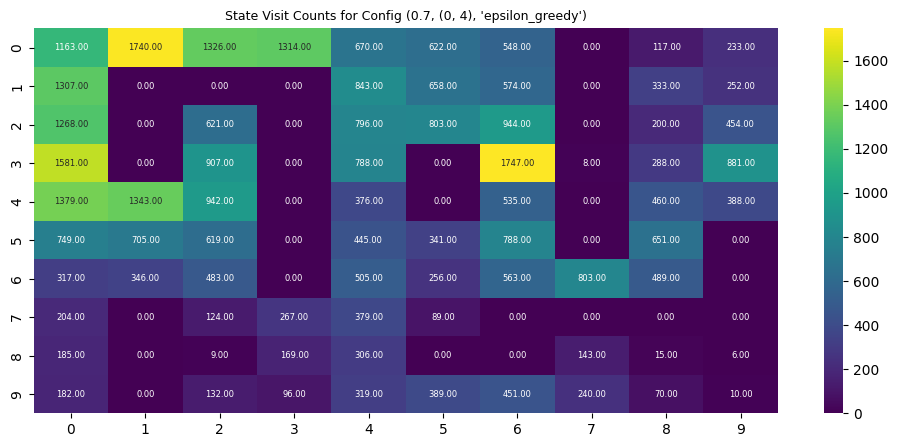

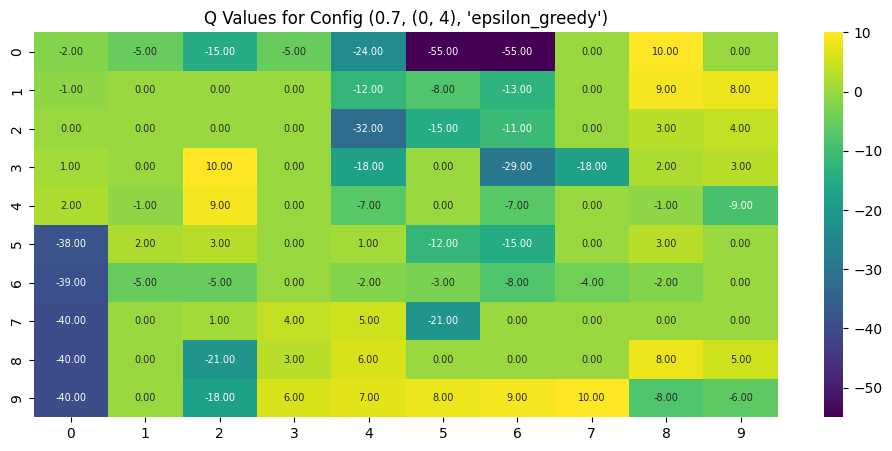

In [134]:
QLearning_Execution(configs[2])


#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (0,4)

Value of $p$ = 0.7

Exploration strategy = Softmax

Best Configuration: (0.7, (0, 4), 'softmax')
Best Hyperparameters: alpha = 1 , gamma = 1 , strategy_value = 0.01
Best Rewards: -31358.0
Best Steps: 1000


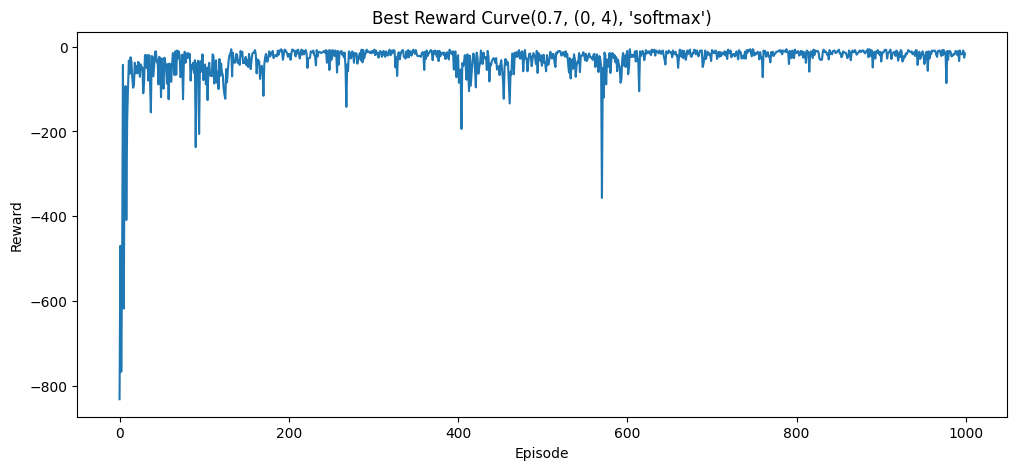

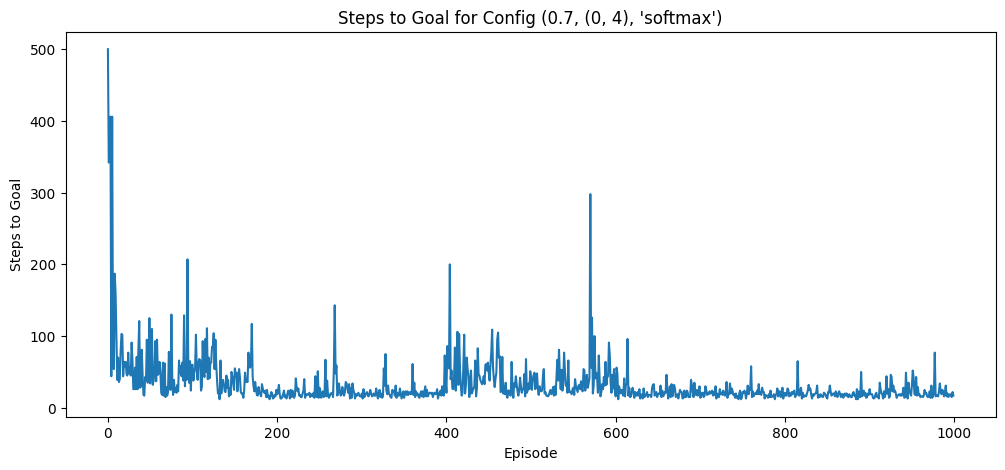

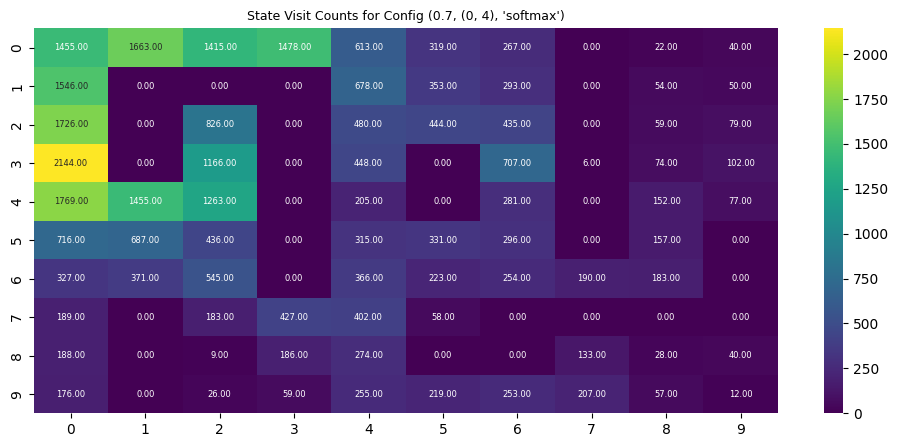

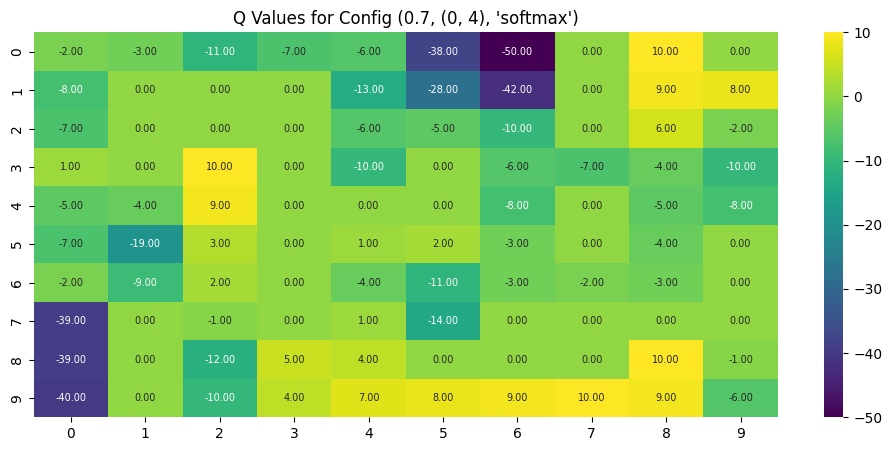

In [136]:
QLearning_Execution(configs[3])


#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = Epsilon Greedy

Best Configuration: (1, (3, 6), 'epsilon_greedy')
Best Hyperparameters: alpha = 1 , gamma = 0.8 , strategy_value = 0.01
Best Rewards: -5356.0
Best Steps: 1000


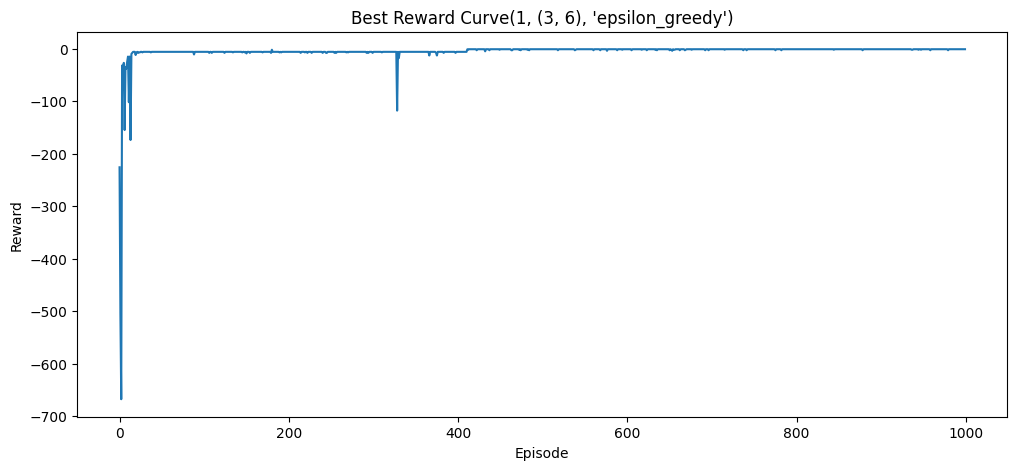

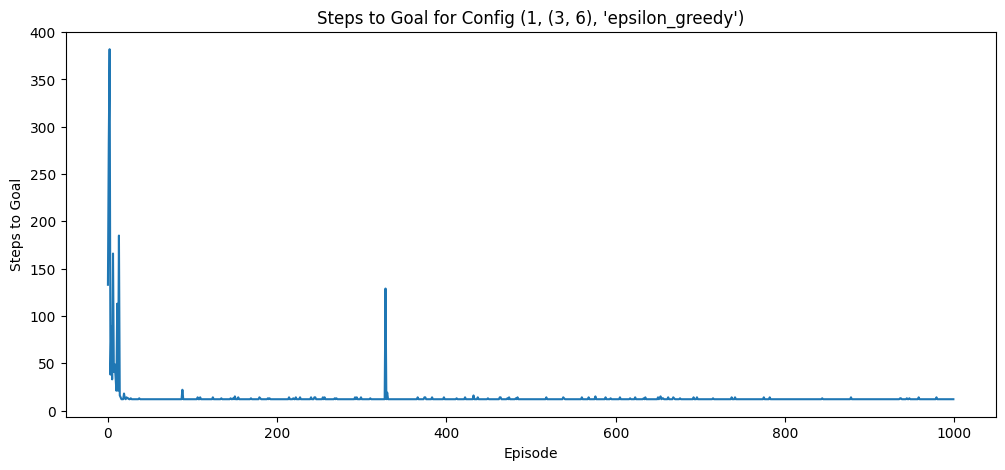

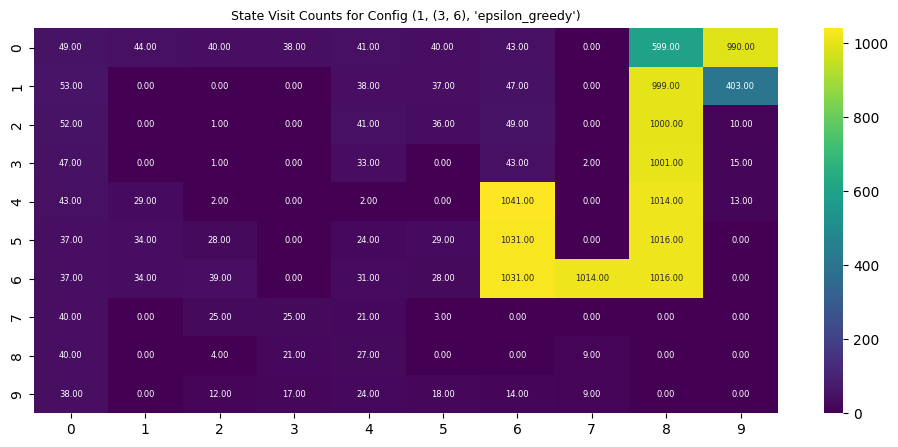

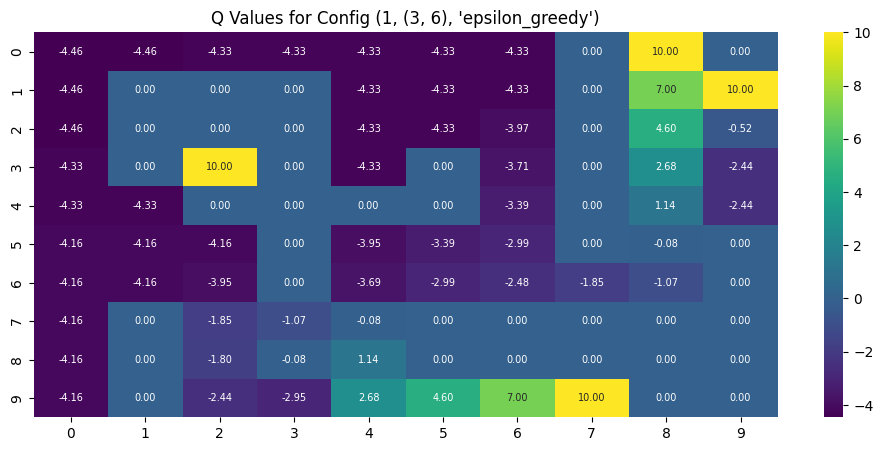

In [138]:
QLearning_Execution(configs[4])


#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = Softmax

Best Configuration: (1, (3, 6), 'softmax')
Best Hyperparameters: alpha = 1 , gamma = 1 , strategy_value = 0.1
Best Rewards: -3311.0
Best Steps: 1000


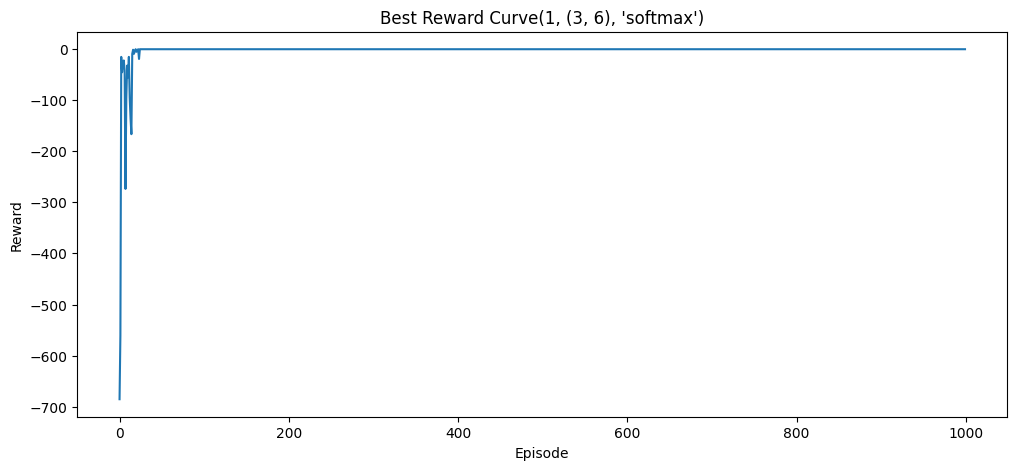

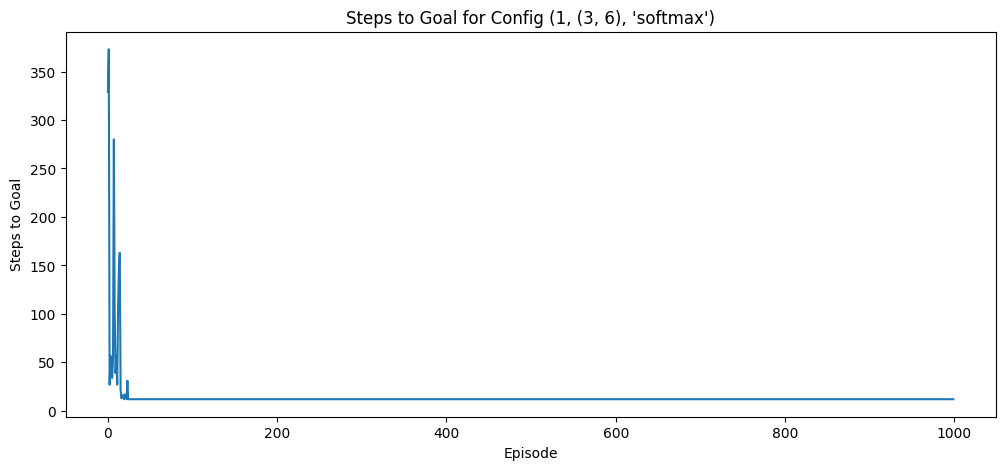

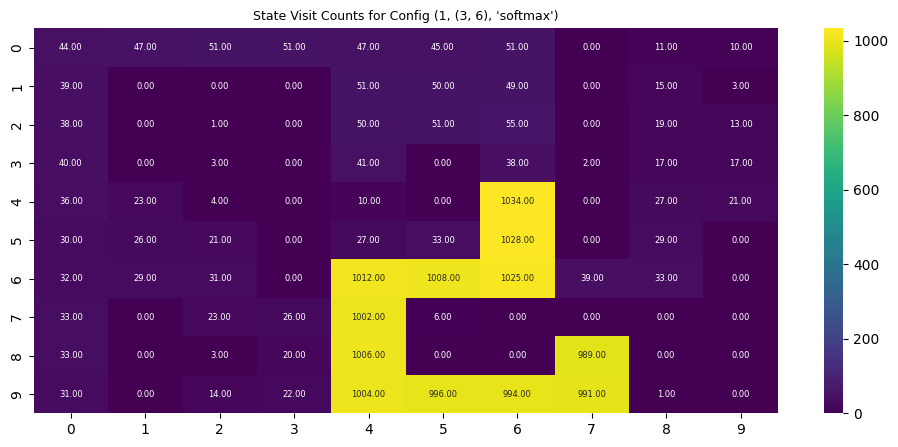

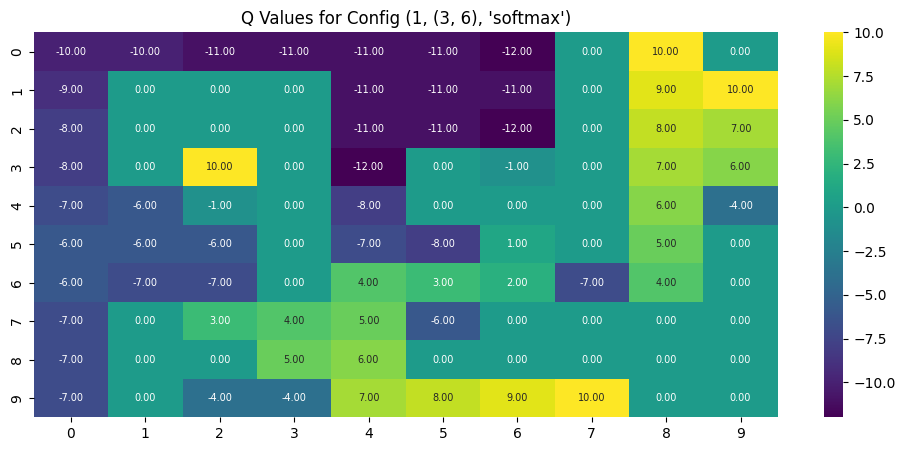

In [140]:
QLearning_Execution(configs[5])


#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (3,6)

Value of $p$ = 0.7

Exploration strategy = Epsilon Greedy

Best Configuration: (0.7, (3, 6), 'epsilon_greedy')
Best Hyperparameters: alpha = 1 , gamma = 1 , strategy_value = 0.001
Best Rewards: -36507.0
Best Steps: 1000


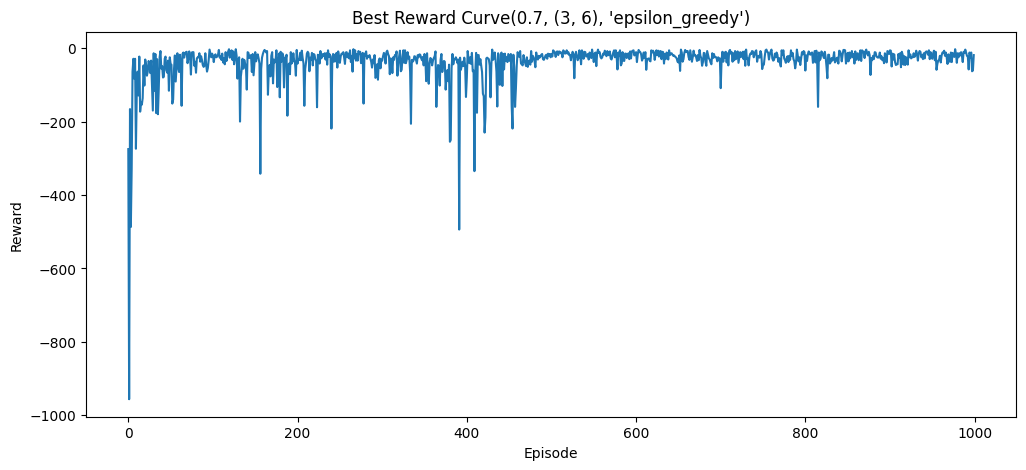

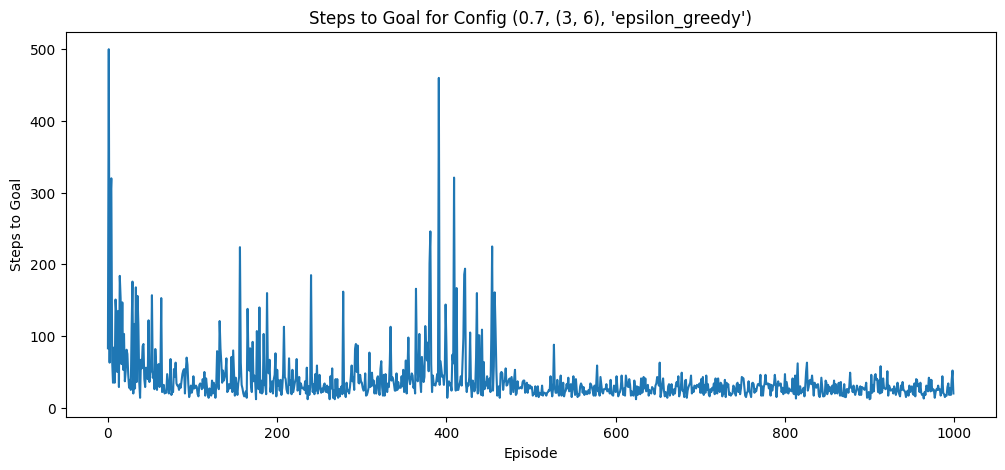

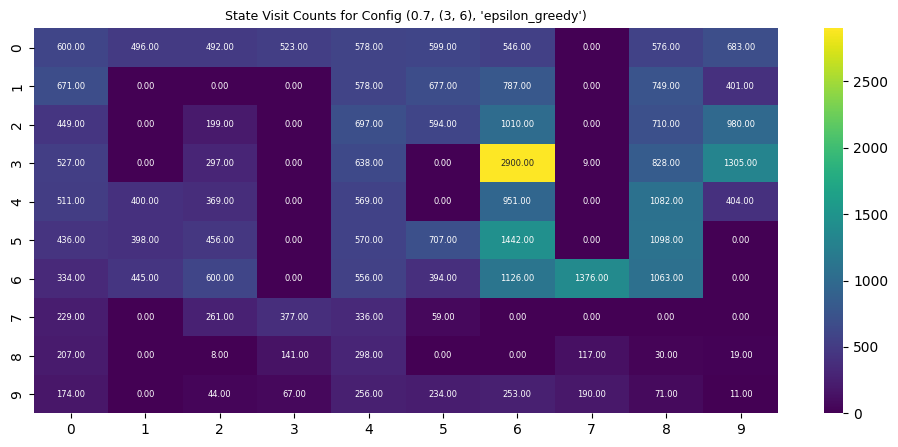

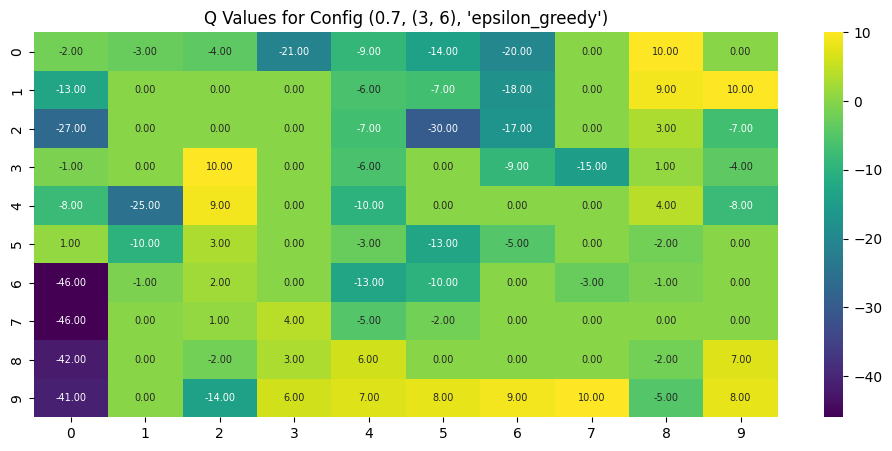

In [142]:
QLearning_Execution(configs[6])


#### Configuration Parameters
Learning algorithm = QLearning

Wind = False

Start State = (3,6)

Value of $p$ = 0.7

Exploration strategy = Softmax

Best Configuration: (0.7, (3, 6), 'softmax')
Best Hyperparameters: alpha = 1 , gamma = 1 , strategy_value = 0.1
Best Rewards: -39770.0
Best Steps: 1000


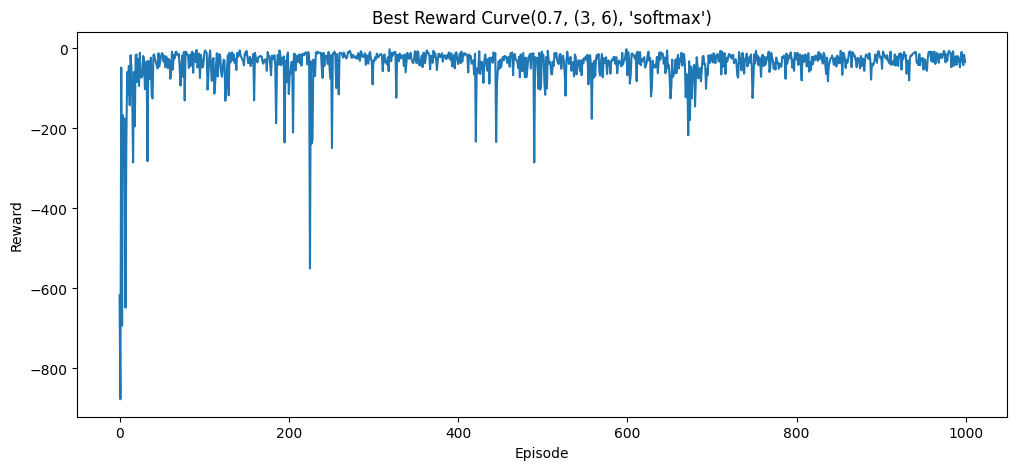

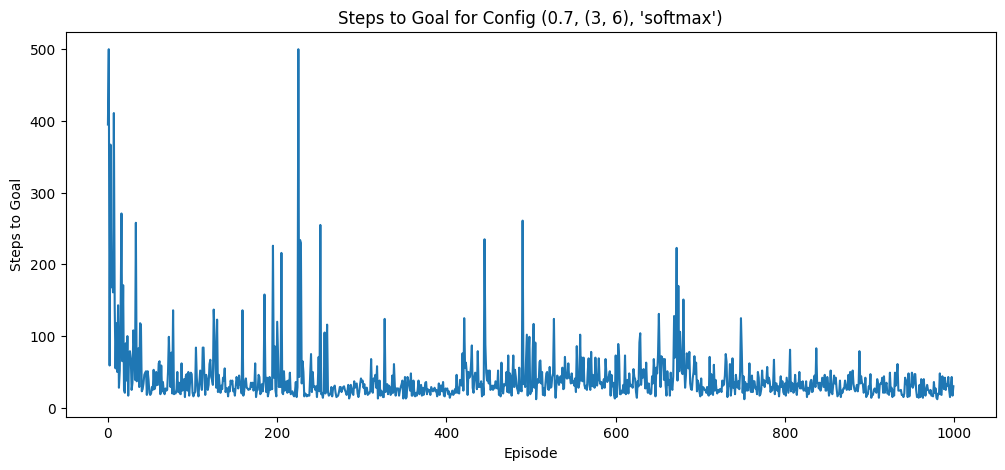

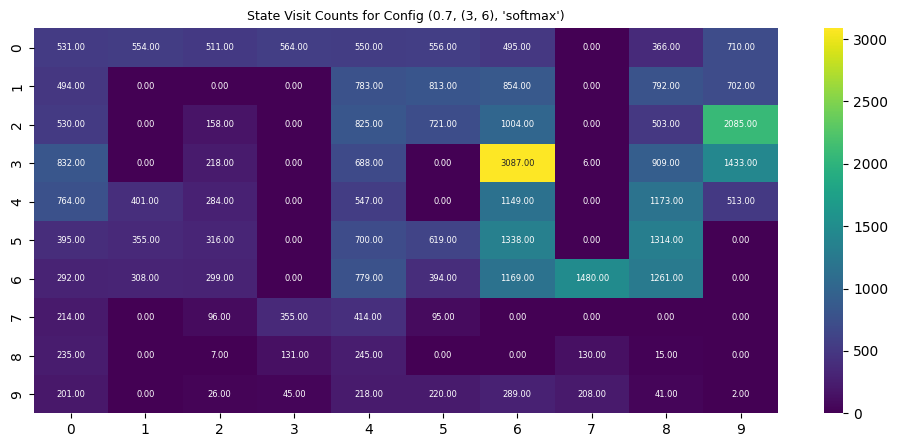

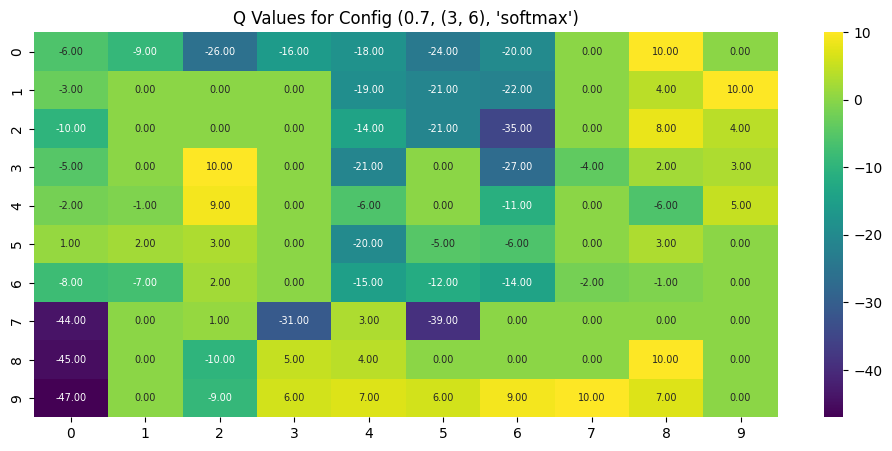

In [144]:
QLearning_Execution(configs[7])


## Analysis [36 Marks]

### SARSA [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Your Answer:
The SARSA agent learned policies that generally improved over time, as evidenced by the increasing reward curves and decreasing steps to goal across episodes. The best hyperparameters were consistently:

- Learning rate (alpha): 1.0 in all cases
- Discount factor (gamma): 0.9 or 1.0
- For epsilon-greedy: epsilon = 0.001
- For softmax: temperature = 0.1 or 0.01

This combination allows for rapid learning (high alpha) while considering long-term rewards (high gamma). The low epsilon and temperature values suggest that exploitation was favored over exploration after initial learning.

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer:
Impact of Wind:

**With start state (0,4) and epsilon-greedy:**

- Wind = False: Best Rewards: -10500.0
- Wind= True: Best Rewards: -14562.0

**With start state (0,4) and softmax:**

- Wind = False: Best Rewards: -13392.0
- Wind= True: Best Rewards: -14914.0

The presence of wind generally decreased the total rewards, likely due to the added unpredictability in state transitions. The effect seems more pronounced with the epsilon-greedy strategy.

Impact of Start States:

**For epsilon-greedy wind= False:**

- Start (0,4): Best Rewards: -10500.0
- Start (3,6): Best Rewards: -8393.0

**For softmax wind= False:**

- Start (0,4): Best Rewards: -13392.0
- Start (3,6): Best Rewards: -3577.0

The (3,6) start state consistently resulted in better performance than (0,4), likely because it's closer to goal states or provides easier access to rewarding paths.

**Exploration Strategies:**

- wind =False, softmax exploration performed better than epsilon-greedy for the (3,6) start state, but worse for the (0,4) start state. This suggests that the effectiveness of the exploration strategy depends on the initial position in the environment.

- wind= True, epsilon-greedy slightly outperformed softmax for the (0,4) start state, while softmax significantly outperformed epsilon-greedy for the (3,6) start state. This indicates that softmax may be more effective in handling the added stochasticity from wind, particularly when starting from a more advantageous position.

**State Visit Counts and Q-Values:**

- The heatmaps of state visit counts show clear "hot paths" that the agent learns to follow, avoiding obstacles and bad states. The Q-value heatmaps reveal the learned value function, with higher values near goal states and lower values near obstacles or bad states.

### Q Learning [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Your Answer:

**Policy Learned:**

Effective navigation towards goals while avoiding obstacles and penalties
Risk-averse behavior, preferring safer paths
Adaptation to different start states

**Hyperparameters:**

- Learning rate (alpha): Consistently 1.0, enabling rapid learning
- Discount factor (gamma): High (0.8-1.0), emphasizing long-term rewards
Exploration:
- Epsilon-greedy: epsilon = 0.001-0.01
- Softmax: temperature = 0.01-0.1

**Key observations:**

- High learning rate beneficial for quick adaptation
- Higher discount factors used in more stochastic environments (p=0.7)
- Low exploration parameters suggest quick convergence to exploitation
- Slight variations in optimal hyperparameters across configurations highlight the importance of tuning for specific scenarios

The agent learned effective policies for navigating the grid world, with hyperparameters balancing rapid learning, long-term planning, and limited exploration.

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer:

*Impact of Stochasticity (p values):*

**With start state (0,4) and epsilon-greedy:**

- p = 1.0: Best Rewards: -14209.0

- p = 0.7: Best Rewards: -39315.0

**With start state (0,4) and softmax:**

- p = 1.0: Best Rewards: -8338.0

- p = 0.7: Best Rewards: -31358.0

The higher stochasticity (p = 0.7) significantly decreased the total rewards compared to the deterministic case (p = 1.0). This demonstrates that Q-Learning's performance is highly sensitive to environmental uncertainty.

**Impact of Start States:**

For epsilon-greedy with p = 1.0:

- Start (0,4): Best Rewards: -14209.0

- Start (3,6): Best Rewards: -5356.0

For softmax with p = 1.0:

- Start (0,4): Best Rewards: -8338.0

- Start (3,6): Best Rewards: -3311.0

The (3,6) start state consistently resulted in better performance than (0,4), regardless of the p value or exploration strategy. This suggests that (3,6) is a more advantageous starting position in the grid world.

**Exploration Strategies:**

With p = 1.0:

- Start (0,4): Softmax (-8338.0) outperformed epsilon-greedy (-14209.0)

- Start (3,6): Softmax (-3311.0) outperformed epsilon-greedy (-5356.0)

With p = 0.7:

- Start (0,4): Softmax (-31358.0) outperformed epsilon-greedy (-39315.0)

- Start (3,6): Epsilon-greedy (-36507.0) outperformed softmax (-39770.0)

Softmax exploration generally performed better than epsilon-greedy, especially in the deterministic environment (p = 1.0). However, with higher stochasticity (p = 0.7), the advantage of softmax was less consistent, with epsilon-greedy performing better for the (3,6) start state.

**State Visit Counts and Q-Values:**

The heatmaps of state visit counts show clear "hot paths" that the agent learns to follow, avoiding obstacles and bad states. The Q-value heatmaps reveal the learned value function, with higher values near goal states and lower values near obstacles or bad states. These patterns are more distinct in the deterministic cases (p = 1.0) compared to the stochastic cases (p = 0.7).

In conclusion, Q-Learning demonstrated effective learning in this grid world environment, but its performance was heavily influenced by the level of environmental stochasticity (p value) and the start state. The choice of exploration strategy (epsilon-greedy vs softmax) had varying impacts depending on these factors, with softmax generally performing better in deterministic conditions but showing mixed results in more stochastic conditions. The significant drop in performance when p changed from 1.0 to 0.7 highlights the challenge Q-Learning faces in highly stochastic environments and the importance of adapting learning strategies to the level of environmental uncertainty.